# Two-qubit States Reconstruction

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [6]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [7]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [9]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [10]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [11]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [12]:
A = tf.stack([X_tf,Y_tf,Z_tf])

In [13]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = 1 - fidelity
   return infidelity 

In [14]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   return infidelity 

## Noise Model

In [15]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [16]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [17]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [18]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [19]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [20]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [21]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [22]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [23]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 74ms/step - loss: 0.2090 - val_loss: 0.1980
Epoch 2/500
6/6 [==============================] - 0s 15ms/step - loss: 0.1926 - val_loss: 0.1855
Epoch 3/500
6/6 [==============================] - 0s 14ms/step - loss: 0.1799 - val_loss: 0.1748
Epoch 4/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1685 - val_loss: 0.1649
Epoch 5/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1576 - val_loss: 0.1551
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1467 - val_loss: 0.1449
Epoch 7/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1353 - val_loss: 0.1345
Epoch 8/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1238 - val_loss: 0.1238
Epoch 9/500
6/6 [==============================] - 0s 14ms/step - loss: 0.1121 - val_loss: 0.1129
Epoch 10/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1005 - val_loss: 0.1022
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 85/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 86/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 87/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 88/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 89/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 90/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 91/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 92/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 93/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 94/5

6/6 [==============================] - 0s 12ms/step - loss: 5.3430e-04 - val_loss: 0.0015
Epoch 164/500
6/6 [==============================] - 0s 11ms/step - loss: 5.2323e-04 - val_loss: 0.0014
Epoch 165/500
6/6 [==============================] - 0s 14ms/step - loss: 5.0691e-04 - val_loss: 0.0014
Epoch 166/500
6/6 [==============================] - 0s 12ms/step - loss: 5.0867e-04 - val_loss: 0.0014
Epoch 167/500
6/6 [==============================] - 0s 12ms/step - loss: 5.0368e-04 - val_loss: 0.0014
Epoch 168/500
6/6 [==============================] - 0s 11ms/step - loss: 4.9230e-04 - val_loss: 0.0014
Epoch 169/500
6/6 [==============================] - 0s 12ms/step - loss: 4.9034e-04 - val_loss: 0.0014
Epoch 170/500
6/6 [==============================] - 0s 12ms/step - loss: 4.8437e-04 - val_loss: 0.0014
Epoch 171/500
6/6 [==============================] - 0s 13ms/step - loss: 4.8661e-04 - val_loss: 0.0014
Epoch 172/500
6/6 [==============================] - 0s 12ms/step - loss: 4.88

Epoch 242/500
6/6 [==============================] - 0s 12ms/step - loss: 3.1820e-04 - val_loss: 0.0011
Epoch 243/500
6/6 [==============================] - 0s 12ms/step - loss: 3.1640e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 12ms/step - loss: 3.2168e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 13ms/step - loss: 3.2289e-04 - val_loss: 0.0010
Epoch 246/500
6/6 [==============================] - 0s 11ms/step - loss: 3.1699e-04 - val_loss: 0.0010
Epoch 247/500
6/6 [==============================] - 0s 11ms/step - loss: 3.2016e-04 - val_loss: 0.0010
Epoch 248/500
6/6 [==============================] - 0s 11ms/step - loss: 3.2123e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 12ms/step - loss: 3.2412e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 11ms/step - loss: 3.2041e-04 - val_loss: 0.0010
Epoch 251/500
6/6 [==============================] - 0s 12ms/ste

6/6 [==============================] - 0s 12ms/step - loss: 2.2723e-04 - val_loss: 8.3593e-04
Epoch 319/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2755e-04 - val_loss: 8.5157e-04
Epoch 320/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2733e-04 - val_loss: 8.5024e-04
Epoch 321/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2059e-04 - val_loss: 8.3887e-04
Epoch 322/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2327e-04 - val_loss: 8.2370e-04
Epoch 323/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2295e-04 - val_loss: 8.3454e-04
Epoch 324/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2578e-04 - val_loss: 8.2416e-04
Epoch 325/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2160e-04 - val_loss: 8.2470e-04
Epoch 326/500
6/6 [==============================] - 0s 12ms/step - loss: 2.1565e-04 - val_loss: 8.1599e-04
Epoch 327/500
6/6 [=======================

Epoch 394/500
6/6 [==============================] - 0s 13ms/step - loss: 1.6757e-04 - val_loss: 6.8865e-04
Epoch 395/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6495e-04 - val_loss: 6.7646e-04
Epoch 396/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6545e-04 - val_loss: 6.8129e-04
Epoch 397/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6462e-04 - val_loss: 6.8965e-04
Epoch 398/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6407e-04 - val_loss: 6.7326e-04
Epoch 399/500
6/6 [==============================] - 0s 11ms/step - loss: 1.6194e-04 - val_loss: 6.7316e-04
Epoch 400/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6159e-04 - val_loss: 6.7402e-04
Epoch 401/500
6/6 [==============================] - 0s 11ms/step - loss: 1.6262e-04 - val_loss: 6.7928e-04
Epoch 402/500
6/6 [==============================] - 0s 12ms/step - loss: 1.6760e-04 - val_loss: 6.8397e-04
Epoch 403/500
6/6 [=========

Epoch 470/500
6/6 [==============================] - 0s 13ms/step - loss: 1.2887e-04 - val_loss: 5.7761e-04
Epoch 471/500
6/6 [==============================] - 0s 13ms/step - loss: 1.2939e-04 - val_loss: 5.7692e-04
Epoch 472/500
6/6 [==============================] - 0s 12ms/step - loss: 1.2984e-04 - val_loss: 5.7477e-04
Epoch 473/500
6/6 [==============================] - 0s 12ms/step - loss: 1.2982e-04 - val_loss: 5.7609e-04
Epoch 474/500
6/6 [==============================] - 0s 12ms/step - loss: 1.3606e-04 - val_loss: 5.7749e-04
Epoch 475/500
6/6 [==============================] - 0s 11ms/step - loss: 1.3359e-04 - val_loss: 5.8368e-04
Epoch 476/500
6/6 [==============================] - 0s 12ms/step - loss: 1.3845e-04 - val_loss: 5.7726e-04
Epoch 477/500
6/6 [==============================] - 0s 11ms/step - loss: 1.3524e-04 - val_loss: 5.6750e-04
Epoch 478/500
6/6 [==============================] - 0s 14ms/step - loss: 1.3085e-04 - val_loss: 5.7183e-04
Epoch 479/500
6/6 [=========

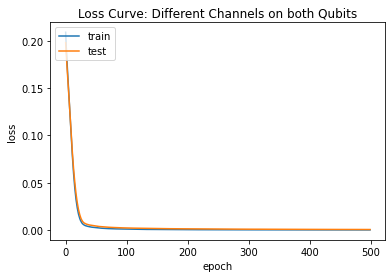

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.4060e-04 - 168ms/epoch - 24ms/step


In [26]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.9942133+1.5286838e-05j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [27]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [28]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [29]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [30]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [31]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [32]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0008)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [33]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 1s 61ms/step - loss: 0.2066 - val_loss: 0.1997
Epoch 2/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1939 - val_loss: 0.1893
Epoch 3/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1831 - val_loss: 0.1799
Epoch 4/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1732 - val_loss: 0.1711
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1637 - val_loss: 0.1623
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1541 - val_loss: 0.1534
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1445 - val_loss: 0.1440
Epoch 8/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1347 - val_loss: 0.1343
Epoch 9/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1245 - val_loss: 0.1247
Epoch 10/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1144 - val_loss: 0.1148
Epoch 11/500
6/6 [==

6/6 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 85/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 86/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 87/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 88/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 89/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 90/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 91/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 92/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 93/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 94/500
6/6 [==========

Epoch 165/500
6/6 [==============================] - 0s 9ms/step - loss: 6.6699e-04 - val_loss: 0.0016
Epoch 166/500
6/6 [==============================] - 0s 10ms/step - loss: 6.4718e-04 - val_loss: 0.0016
Epoch 167/500
6/6 [==============================] - 0s 10ms/step - loss: 6.3220e-04 - val_loss: 0.0016
Epoch 168/500
6/6 [==============================] - 0s 9ms/step - loss: 6.3466e-04 - val_loss: 0.0016
Epoch 169/500
6/6 [==============================] - 0s 10ms/step - loss: 6.2706e-04 - val_loss: 0.0016
Epoch 170/500
6/6 [==============================] - 0s 10ms/step - loss: 6.2094e-04 - val_loss: 0.0016
Epoch 171/500
6/6 [==============================] - 0s 9ms/step - loss: 6.1902e-04 - val_loss: 0.0016
Epoch 172/500
6/6 [==============================] - 0s 9ms/step - loss: 6.2459e-04 - val_loss: 0.0016
Epoch 173/500
6/6 [==============================] - 0s 9ms/step - loss: 6.2431e-04 - val_loss: 0.0016
Epoch 174/500
6/6 [==============================] - 0s 10ms/step - l

6/6 [==============================] - 0s 11ms/step - loss: 4.0735e-04 - val_loss: 0.0012
Epoch 245/500
6/6 [==============================] - 0s 10ms/step - loss: 4.0578e-04 - val_loss: 0.0012
Epoch 246/500
6/6 [==============================] - 0s 10ms/step - loss: 4.0030e-04 - val_loss: 0.0012
Epoch 247/500
6/6 [==============================] - 0s 10ms/step - loss: 3.9937e-04 - val_loss: 0.0012
Epoch 248/500
6/6 [==============================] - 0s 9ms/step - loss: 4.0283e-04 - val_loss: 0.0012
Epoch 249/500
6/6 [==============================] - 0s 11ms/step - loss: 3.9366e-04 - val_loss: 0.0012
Epoch 250/500
6/6 [==============================] - 0s 9ms/step - loss: 3.8930e-04 - val_loss: 0.0012
Epoch 251/500
6/6 [==============================] - 0s 9ms/step - loss: 3.9074e-04 - val_loss: 0.0012
Epoch 252/500
6/6 [==============================] - 0s 9ms/step - loss: 3.9388e-04 - val_loss: 0.0012
Epoch 253/500
6/6 [==============================] - 0s 9ms/step - loss: 3.8461e-0

6/6 [==============================] - 0s 9ms/step - loss: 2.8166e-04 - val_loss: 9.9044e-04
Epoch 324/500
6/6 [==============================] - 0s 10ms/step - loss: 2.8330e-04 - val_loss: 9.9194e-04
Epoch 325/500
6/6 [==============================] - 0s 9ms/step - loss: 2.8105e-04 - val_loss: 9.7532e-04
Epoch 326/500
6/6 [==============================] - 0s 10ms/step - loss: 2.7777e-04 - val_loss: 9.8201e-04
Epoch 327/500
6/6 [==============================] - 0s 9ms/step - loss: 2.7956e-04 - val_loss: 9.8060e-04
Epoch 328/500
6/6 [==============================] - 0s 9ms/step - loss: 2.7658e-04 - val_loss: 9.8074e-04
Epoch 329/500
6/6 [==============================] - 0s 10ms/step - loss: 2.8240e-04 - val_loss: 9.7406e-04
Epoch 330/500
6/6 [==============================] - 0s 9ms/step - loss: 2.8692e-04 - val_loss: 9.7030e-04
Epoch 331/500
6/6 [==============================] - 0s 9ms/step - loss: 2.7390e-04 - val_loss: 9.6308e-04
Epoch 332/500
6/6 [=============================

6/6 [==============================] - 0s 10ms/step - loss: 2.0794e-04 - val_loss: 8.4018e-04
Epoch 400/500
6/6 [==============================] - 0s 9ms/step - loss: 2.0990e-04 - val_loss: 8.2720e-04
Epoch 401/500
6/6 [==============================] - 0s 10ms/step - loss: 2.0847e-04 - val_loss: 8.3847e-04
Epoch 402/500
6/6 [==============================] - 0s 9ms/step - loss: 2.0935e-04 - val_loss: 8.3866e-04
Epoch 403/500
6/6 [==============================] - 0s 10ms/step - loss: 2.1046e-04 - val_loss: 8.4175e-04
Epoch 404/500
6/6 [==============================] - 0s 10ms/step - loss: 2.0854e-04 - val_loss: 8.2188e-04
Epoch 405/500
6/6 [==============================] - 0s 10ms/step - loss: 2.0375e-04 - val_loss: 8.1439e-04
Epoch 406/500
6/6 [==============================] - 0s 11ms/step - loss: 2.0385e-04 - val_loss: 8.1513e-04
Epoch 407/500
6/6 [==============================] - 0s 10ms/step - loss: 2.0448e-04 - val_loss: 8.3157e-04
Epoch 408/500
6/6 [=========================

6/6 [==============================] - 0s 10ms/step - loss: 1.6098e-04 - val_loss: 7.1223e-04
Epoch 476/500
6/6 [==============================] - 0s 9ms/step - loss: 1.5832e-04 - val_loss: 7.1055e-04
Epoch 477/500
6/6 [==============================] - 0s 9ms/step - loss: 1.6158e-04 - val_loss: 7.0914e-04
Epoch 478/500
6/6 [==============================] - 0s 9ms/step - loss: 1.6487e-04 - val_loss: 7.0563e-04
Epoch 479/500
6/6 [==============================] - 0s 10ms/step - loss: 1.5691e-04 - val_loss: 7.0660e-04
Epoch 480/500
6/6 [==============================] - 0s 10ms/step - loss: 1.6154e-04 - val_loss: 7.1032e-04
Epoch 481/500
6/6 [==============================] - 0s 9ms/step - loss: 1.6175e-04 - val_loss: 7.0596e-04
Epoch 482/500
6/6 [==============================] - 0s 9ms/step - loss: 1.5375e-04 - val_loss: 7.0084e-04
Epoch 483/500
6/6 [==============================] - 0s 10ms/step - loss: 1.5540e-04 - val_loss: 7.0172e-04
Epoch 484/500
6/6 [============================

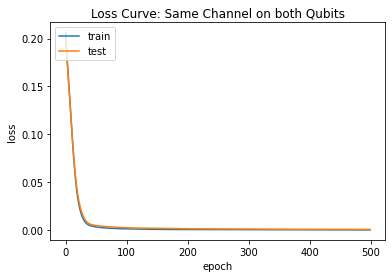

In [34]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 7.4648e-04 - 107ms/epoch - 15ms/step


In [36]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.9922432-2.1850722e-06j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [37]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [38]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [39]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [40]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [41]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [42]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [43]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 1s 38ms/step - loss: 0.2025 - val_loss: 0.1926
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1822 - val_loss: 0.1770
Epoch 3/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1656 - val_loss: 0.1630
Epoch 4/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1506 - val_loss: 0.1493
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1362 - val_loss: 0.1359
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1220 - val_loss: 0.1225
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1081 - val_loss: 0.1093
Epoch 8/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0947 - val_loss: 0.0968
Epoch 9/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0823 - val_loss: 0.0852
Epoch 10/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0709 - val_loss: 0.0744
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 85/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 86/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 87/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 88/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 89/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 90/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 91/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 92/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 93/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 94/500


6/6 [==============================] - 0s 12ms/step - loss: 7.5414e-04 - val_loss: 0.0022
Epoch 165/500
6/6 [==============================] - 0s 13ms/step - loss: 7.3870e-04 - val_loss: 0.0022
Epoch 166/500
6/6 [==============================] - 0s 11ms/step - loss: 7.3188e-04 - val_loss: 0.0022
Epoch 167/500
6/6 [==============================] - 0s 9ms/step - loss: 7.2819e-04 - val_loss: 0.0022
Epoch 168/500
6/6 [==============================] - 0s 10ms/step - loss: 7.2621e-04 - val_loss: 0.0022
Epoch 169/500
6/6 [==============================] - 0s 12ms/step - loss: 7.3231e-04 - val_loss: 0.0022
Epoch 170/500
6/6 [==============================] - 0s 12ms/step - loss: 7.2438e-04 - val_loss: 0.0022
Epoch 171/500
6/6 [==============================] - 0s 11ms/step - loss: 7.2013e-04 - val_loss: 0.0022
Epoch 172/500
6/6 [==============================] - 0s 10ms/step - loss: 7.1991e-04 - val_loss: 0.0021
Epoch 173/500
6/6 [==============================] - 0s 10ms/step - loss: 7.080

Epoch 243/500
6/6 [==============================] - 0s 11ms/step - loss: 5.0017e-04 - val_loss: 0.0019
Epoch 244/500
6/6 [==============================] - 0s 10ms/step - loss: 4.9769e-04 - val_loss: 0.0019
Epoch 245/500
6/6 [==============================] - 0s 11ms/step - loss: 4.9818e-04 - val_loss: 0.0019
Epoch 246/500
6/6 [==============================] - 0s 11ms/step - loss: 4.8540e-04 - val_loss: 0.0018
Epoch 247/500
6/6 [==============================] - 0s 11ms/step - loss: 4.8202e-04 - val_loss: 0.0019
Epoch 248/500
6/6 [==============================] - 0s 12ms/step - loss: 4.8191e-04 - val_loss: 0.0019
Epoch 249/500
6/6 [==============================] - 0s 12ms/step - loss: 4.8317e-04 - val_loss: 0.0018
Epoch 250/500
6/6 [==============================] - 0s 11ms/step - loss: 4.8045e-04 - val_loss: 0.0019
Epoch 251/500
6/6 [==============================] - 0s 10ms/step - loss: 4.7101e-04 - val_loss: 0.0018
Epoch 252/500
6/6 [==============================] - 0s 11ms/ste

Epoch 322/500
6/6 [==============================] - 0s 11ms/step - loss: 3.5386e-04 - val_loss: 0.0017
Epoch 323/500
6/6 [==============================] - 0s 12ms/step - loss: 3.5088e-04 - val_loss: 0.0017
Epoch 324/500
6/6 [==============================] - 0s 11ms/step - loss: 3.4990e-04 - val_loss: 0.0017
Epoch 325/500
6/6 [==============================] - 0s 10ms/step - loss: 3.5308e-04 - val_loss: 0.0017
Epoch 326/500
6/6 [==============================] - 0s 11ms/step - loss: 3.4966e-04 - val_loss: 0.0017
Epoch 327/500
6/6 [==============================] - 0s 11ms/step - loss: 3.5616e-04 - val_loss: 0.0017
Epoch 328/500
6/6 [==============================] - 0s 13ms/step - loss: 3.5374e-04 - val_loss: 0.0017
Epoch 329/500
6/6 [==============================] - 0s 13ms/step - loss: 3.5512e-04 - val_loss: 0.0017
Epoch 330/500
6/6 [==============================] - 0s 12ms/step - loss: 3.5193e-04 - val_loss: 0.0017
Epoch 331/500
6/6 [==============================] - 0s 12ms/ste

Epoch 401/500
6/6 [==============================] - 0s 10ms/step - loss: 2.8239e-04 - val_loss: 0.0016
Epoch 402/500
6/6 [==============================] - 0s 9ms/step - loss: 2.8530e-04 - val_loss: 0.0016
Epoch 403/500
6/6 [==============================] - 0s 10ms/step - loss: 2.7722e-04 - val_loss: 0.0016
Epoch 404/500
6/6 [==============================] - 0s 10ms/step - loss: 2.6955e-04 - val_loss: 0.0016
Epoch 405/500
6/6 [==============================] - 0s 10ms/step - loss: 2.7730e-04 - val_loss: 0.0016
Epoch 406/500
6/6 [==============================] - 0s 10ms/step - loss: 2.6792e-04 - val_loss: 0.0016
Epoch 407/500
6/6 [==============================] - 0s 10ms/step - loss: 2.6752e-04 - val_loss: 0.0016
Epoch 408/500
6/6 [==============================] - 0s 10ms/step - loss: 2.6858e-04 - val_loss: 0.0016
Epoch 409/500
6/6 [==============================] - 0s 11ms/step - loss: 2.7033e-04 - val_loss: 0.0016
Epoch 410/500
6/6 [==============================] - 0s 11ms/step

Epoch 480/500
6/6 [==============================] - 0s 12ms/step - loss: 2.2851e-04 - val_loss: 0.0016
Epoch 481/500
6/6 [==============================] - 0s 10ms/step - loss: 2.3116e-04 - val_loss: 0.0016
Epoch 482/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2747e-04 - val_loss: 0.0016
Epoch 483/500
6/6 [==============================] - 0s 10ms/step - loss: 2.3052e-04 - val_loss: 0.0016
Epoch 484/500
6/6 [==============================] - 0s 9ms/step - loss: 2.3790e-04 - val_loss: 0.0015
Epoch 485/500
6/6 [==============================] - 0s 10ms/step - loss: 2.3143e-04 - val_loss: 0.0015
Epoch 486/500
6/6 [==============================] - 0s 10ms/step - loss: 2.3235e-04 - val_loss: 0.0015
Epoch 487/500
6/6 [==============================] - 0s 10ms/step - loss: 2.2600e-04 - val_loss: 0.0015
Epoch 488/500
6/6 [==============================] - 0s 11ms/step - loss: 2.2545e-04 - val_loss: 0.0015
Epoch 489/500
6/6 [==============================] - 0s 10ms/step

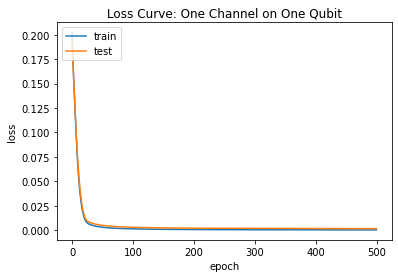

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0014 - 102ms/epoch - 15ms/step


In [46]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.99235076+1.9622298e-06j), shape=(), dtype=complex64)


## <font color='red'>Training the Algorithm (INF)</font>

### <font color='red'>Different Channels on both Qubits</font>

In [47]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [48]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [49]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [50]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[800:900]
y_val_list = vectors_noise_free[800:900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[900:]
y_test_list = vectors_noise_free[900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [51]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'),    
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [52]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0002)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [53]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=4000)

Epoch 1/4000
8/8 [==============================] - 1s 27ms/step - loss: 0.7032 - val_loss: 0.6794
Epoch 2/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.6676 - val_loss: 0.6463
Epoch 3/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.6315 - val_loss: 0.6127
Epoch 4/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.5962 - val_loss: 0.5786
Epoch 5/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.5597 - val_loss: 0.5439
Epoch 6/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.5239 - val_loss: 0.5093
Epoch 7/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.4887 - val_loss: 0.4757
Epoch 8/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.4556 - val_loss: 0.4437
Epoch 9/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.4242 - val_loss: 0.4138
Epoch 10/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.3953 - val_loss: 0.3858
Epoch 11/4000
8/8 

Epoch 84/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - val_loss: 0.0269
Epoch 85/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0266
Epoch 86/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.0262
Epoch 87/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - val_loss: 0.0258
Epoch 88/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0254
Epoch 89/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - val_loss: 0.0251
Epoch 90/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - val_loss: 0.0246
Epoch 91/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0212 - val_loss: 0.0243
Epoch 92/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.0239
Epoch 93/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.0236
Epoch 94/4

8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0114
Epoch 167/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0113
Epoch 168/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 169/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0112
Epoch 170/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 171/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0110
Epoch 172/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0109
Epoch 173/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0109
Epoch 174/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 175/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 176/4000


Epoch 248/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 249/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 250/4000
8/8 [==============================] - 0s 23ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 251/4000
8/8 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 252/4000
8/8 [==============================] - 0s 21ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 253/4000
8/8 [==============================] - 0s 32ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 254/4000
8/8 [==============================] - 0s 29ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 255/4000
8/8 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 256/4000
8/8 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 257/4000
8/8 [==============================] - 0s 22ms/step - loss: 0.0048 - val_los

8/8 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 330/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 331/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 332/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 333/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 334/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 335/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 336/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 337/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 338/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 339/

Epoch 411/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 412/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 413/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 414/4000
8/8 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 415/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 416/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 417/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 418/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 419/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 420/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0035

Epoch 493/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 494/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 495/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 496/4000
8/8 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 497/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 498/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 499/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 500/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 501/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 502/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0028

8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 575/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 576/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 577/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 578/4000
8/8 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 579/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 580/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 581/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 582/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 583/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 584/400

Epoch 656/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 657/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 658/4000
8/8 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 659/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 660/4000
8/8 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 661/4000
8/8 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 662/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 663/4000
8/8 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 664/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.9915e-04 - val_loss: 0.0018
Epoch 665/4000
8/8 [==============================] - 0s 6ms/step - loss: 9.9740e-04 - val_los

8/8 [==============================] - 0s 6ms/step - loss: 7.9401e-04 - val_loss: 0.0015
Epoch 736/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.9424e-04 - val_loss: 0.0015
Epoch 737/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.9502e-04 - val_loss: 0.0015
Epoch 738/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.9778e-04 - val_loss: 0.0015
Epoch 739/4000
8/8 [==============================] - 0s 8ms/step - loss: 7.8928e-04 - val_loss: 0.0015
Epoch 740/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.8351e-04 - val_loss: 0.0015
Epoch 741/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.8169e-04 - val_loss: 0.0015
Epoch 742/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.8040e-04 - val_loss: 0.0015
Epoch 743/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.7799e-04 - val_loss: 0.0015
Epoch 744/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.703

Epoch 814/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.1691e-04 - val_loss: 0.0012
Epoch 815/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.1585e-04 - val_loss: 0.0012
Epoch 816/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.1580e-04 - val_loss: 0.0012
Epoch 817/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.1167e-04 - val_loss: 0.0012
Epoch 818/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.0831e-04 - val_loss: 0.0012
Epoch 819/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.1127e-04 - val_loss: 0.0012
Epoch 820/4000
8/8 [==============================] - 0s 8ms/step - loss: 6.0357e-04 - val_loss: 0.0012
Epoch 821/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.0197e-04 - val_loss: 0.0012
Epoch 822/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.0685e-04 - val_loss: 0.0012
Epoch 823/4000
8/8 [==============================] - 0s 6ms/ste

8/8 [==============================] - 0s 7ms/step - loss: 4.8249e-04 - val_loss: 9.4356e-04
Epoch 893/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.8173e-04 - val_loss: 9.3167e-04
Epoch 894/4000
8/8 [==============================] - 0s 8ms/step - loss: 4.7712e-04 - val_loss: 9.3121e-04
Epoch 895/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.7070e-04 - val_loss: 9.2148e-04
Epoch 896/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.7174e-04 - val_loss: 9.2417e-04
Epoch 897/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.6754e-04 - val_loss: 9.2317e-04
Epoch 898/4000
8/8 [==============================] - 0s 6ms/step - loss: 4.6999e-04 - val_loss: 9.1698e-04
Epoch 899/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.6906e-04 - val_loss: 9.0978e-04
Epoch 900/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.6829e-04 - val_loss: 9.3910e-04
Epoch 901/4000
8/8 [=======================

Epoch 968/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.7437e-04 - val_loss: 7.3585e-04
Epoch 969/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.7736e-04 - val_loss: 7.3110e-04
Epoch 970/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.7415e-04 - val_loss: 7.3000e-04
Epoch 971/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.6911e-04 - val_loss: 7.2538e-04
Epoch 972/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.6702e-04 - val_loss: 7.1156e-04
Epoch 973/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.6194e-04 - val_loss: 7.1957e-04
Epoch 974/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.6498e-04 - val_loss: 7.1878e-04
Epoch 975/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.6092e-04 - val_loss: 7.0836e-04
Epoch 976/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.5896e-04 - val_loss: 7.1246e-04
Epoch 977/4000
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 2.8183e-04 - val_loss: 5.5608e-04
Epoch 1044/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7908e-04 - val_loss: 5.4955e-04
Epoch 1045/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7850e-04 - val_loss: 5.4498e-04
Epoch 1046/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7694e-04 - val_loss: 5.4306e-04
Epoch 1047/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7771e-04 - val_loss: 5.4662e-04
Epoch 1048/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7355e-04 - val_loss: 5.4454e-04
Epoch 1049/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7352e-04 - val_loss: 5.4348e-04
Epoch 1050/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7287e-04 - val_loss: 5.3293e-04
Epoch 1051/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7015e-04 - val_loss: 5.3530e-04
Epoch 1052/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 2.0494e-04 - val_loss: 4.0255e-04
Epoch 1119/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.0337e-04 - val_loss: 3.9564e-04
Epoch 1120/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.0019e-04 - val_loss: 3.9112e-04
Epoch 1121/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.0153e-04 - val_loss: 3.9219e-04
Epoch 1122/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.0165e-04 - val_loss: 3.8502e-04
Epoch 1123/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.9805e-04 - val_loss: 3.8615e-04
Epoch 1124/4000
8/8 [==============================] - 0s 8ms/step - loss: 1.9550e-04 - val_loss: 3.8989e-04
Epoch 1125/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.9264e-04 - val_loss: 3.7871e-04
Epoch 1126/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.9135e-04 - val_loss: 3.7810e-04
Epoch 1127/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.3622e-04 - val_loss: 2.6667e-04
Epoch 1194/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3578e-04 - val_loss: 2.6319e-04
Epoch 1195/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3645e-04 - val_loss: 2.6248e-04
Epoch 1196/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3883e-04 - val_loss: 2.6417e-04
Epoch 1197/4000
8/8 [==============================] - 0s 9ms/step - loss: 1.3701e-04 - val_loss: 2.6172e-04
Epoch 1198/4000
8/8 [==============================] - 0s 8ms/step - loss: 1.3468e-04 - val_loss: 2.6084e-04
Epoch 1199/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3410e-04 - val_loss: 2.5902e-04
Epoch 1200/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3100e-04 - val_loss: 2.5835e-04
Epoch 1201/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3089e-04 - val_loss: 2.5266e-04
Epoch 1202/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 8.8090e-05 - val_loss: 1.7146e-04
Epoch 1269/4000
8/8 [==============================] - 0s 12ms/step - loss: 8.7229e-05 - val_loss: 1.7255e-04
Epoch 1270/4000
8/8 [==============================] - 0s 8ms/step - loss: 8.7148e-05 - val_loss: 1.7114e-04
Epoch 1271/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.8514e-05 - val_loss: 1.7192e-04
Epoch 1272/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.7184e-05 - val_loss: 1.7009e-04
Epoch 1273/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.6438e-05 - val_loss: 1.6833e-04
Epoch 1274/4000
8/8 [==============================] - 0s 6ms/step - loss: 8.4816e-05 - val_loss: 1.7009e-04
Epoch 1275/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.4150e-05 - val_loss: 1.6630e-04
Epoch 1276/4000
8/8 [==============================] - 0s 8ms/step - loss: 8.3503e-05 - val_loss: 1.6814e-04
Epoch 1277/4000
8/8 [=============

8/8 [==============================] - 0s 7ms/step - loss: 5.4750e-05 - val_loss: 1.0957e-04
Epoch 1344/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.5540e-05 - val_loss: 1.1004e-04
Epoch 1345/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.4097e-05 - val_loss: 1.1115e-04
Epoch 1346/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.4433e-05 - val_loss: 1.1124e-04
Epoch 1347/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.3971e-05 - val_loss: 1.0945e-04
Epoch 1348/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.3994e-05 - val_loss: 1.0702e-04
Epoch 1349/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.4005e-05 - val_loss: 1.0566e-04
Epoch 1350/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.2456e-05 - val_loss: 1.0556e-04
Epoch 1351/4000
8/8 [==============================] - 0s 9ms/step - loss: 5.1431e-05 - val_loss: 1.0411e-04
Epoch 1352/4000
8/8 [==============

8/8 [==============================] - 0s 13ms/step - loss: 3.2343e-05 - val_loss: 7.2216e-05
Epoch 1419/4000
8/8 [==============================] - 0s 9ms/step - loss: 3.2118e-05 - val_loss: 6.9060e-05
Epoch 1420/4000
8/8 [==============================] - 0s 9ms/step - loss: 3.1391e-05 - val_loss: 6.6621e-05
Epoch 1421/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.2299e-05 - val_loss: 6.9942e-05
Epoch 1422/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.1926e-05 - val_loss: 6.8636e-05
Epoch 1423/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.0567e-05 - val_loss: 6.6798e-05
Epoch 1424/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.0482e-05 - val_loss: 6.6574e-05
Epoch 1425/4000
8/8 [==============================] - 0s 9ms/step - loss: 3.0158e-05 - val_loss: 6.6318e-05
Epoch 1426/4000
8/8 [==============================] - 0s 8ms/step - loss: 3.0352e-05 - val_loss: 6.6299e-05
Epoch 1427/4000
8/8 [=============

8/8 [==============================] - 0s 8ms/step - loss: 1.6280e-05 - val_loss: 4.2297e-05
Epoch 1494/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.6290e-05 - val_loss: 4.2539e-05
Epoch 1495/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5828e-05 - val_loss: 4.0565e-05
Epoch 1496/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.5417e-05 - val_loss: 4.1171e-05
Epoch 1497/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5538e-05 - val_loss: 4.0667e-05
Epoch 1498/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5142e-05 - val_loss: 4.0196e-05
Epoch 1499/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5014e-05 - val_loss: 4.1051e-05
Epoch 1500/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4673e-05 - val_loss: 3.9558e-05
Epoch 1501/4000
8/8 [==============================] - 0s 8ms/step - loss: 1.4580e-05 - val_loss: 3.8873e-05
Epoch 1502/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 6.6213e-06 - val_loss: 2.3275e-05
Epoch 1569/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.4903e-06 - val_loss: 2.3615e-05
Epoch 1570/4000
8/8 [==============================] - 0s 8ms/step - loss: 6.4146e-06 - val_loss: 2.3218e-05
Epoch 1571/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.6490e-06 - val_loss: 2.3416e-05
Epoch 1572/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.3717e-06 - val_loss: 2.3294e-05
Epoch 1573/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.9984e-06 - val_loss: 2.2621e-05
Epoch 1574/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.9928e-06 - val_loss: 2.3504e-05
Epoch 1575/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.9799e-06 - val_loss: 2.2205e-05
Epoch 1576/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.0461e-06 - val_loss: 2.3020e-05
Epoch 1577/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 2.9858e-06 - val_loss: 1.5482e-05
Epoch 1644/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.9036e-06 - val_loss: 1.4663e-05
Epoch 1645/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8303e-06 - val_loss: 1.4724e-05
Epoch 1646/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6762e-06 - val_loss: 1.4656e-05
Epoch 1647/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.7803e-06 - val_loss: 1.4722e-05
Epoch 1648/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.8562e-06 - val_loss: 1.4953e-05
Epoch 1649/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.1602e-06 - val_loss: 1.4564e-05
Epoch 1650/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8642e-06 - val_loss: 1.4756e-05
Epoch 1651/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6524e-06 - val_loss: 1.4347e-05
Epoch 1652/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 1.4900e-06 - val_loss: 1.1740e-05
Epoch 1719/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.5229e-06 - val_loss: 1.1532e-05
Epoch 1720/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4601e-06 - val_loss: 1.1538e-05
Epoch 1721/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4012e-06 - val_loss: 1.1404e-05
Epoch 1722/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.2369e-06 - val_loss: 1.1679e-05
Epoch 1723/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2942e-06 - val_loss: 1.1717e-05
Epoch 1724/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.3579e-06 - val_loss: 1.1524e-05
Epoch 1725/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.4646e-06 - val_loss: 1.1688e-05
Epoch 1726/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.5850e-06 - val_loss: 1.1786e-05
Epoch 1727/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 8.0340e-07 - val_loss: 9.8717e-06
Epoch 1794/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.8246e-07 - val_loss: 1.0033e-05
Epoch 1795/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.5825e-07 - val_loss: 1.0018e-05
Epoch 1796/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.6160e-07 - val_loss: 9.9778e-06
Epoch 1797/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.0763e-07 - val_loss: 1.0220e-05
Epoch 1798/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.6105e-07 - val_loss: 1.0344e-05
Epoch 1799/4000
8/8 [==============================] - 0s 6ms/step - loss: 8.8573e-07 - val_loss: 9.8789e-06
Epoch 1800/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.0436e-06 - val_loss: 1.0177e-05
Epoch 1801/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1542e-06 - val_loss: 1.0831e-05
Epoch 1802/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 8.7045e-07 - val_loss: 9.3436e-06
Epoch 1869/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.4500e-07 - val_loss: 9.4265e-06
Epoch 1870/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.5785e-07 - val_loss: 9.8830e-06
Epoch 1871/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5801e-06 - val_loss: 9.6756e-06
Epoch 1872/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.7092e-06 - val_loss: 1.1417e-05
Epoch 1873/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.0341e-06 - val_loss: 1.0631e-05
Epoch 1874/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.7375e-06 - val_loss: 1.1252e-05
Epoch 1875/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.9544e-06 - val_loss: 9.3400e-06
Epoch 1876/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.1114e-06 - val_loss: 1.0160e-05
Epoch 1877/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 5.3369e-07 - val_loss: 9.0581e-06
Epoch 1944/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.8912e-07 - val_loss: 9.0343e-06
Epoch 1945/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.7973e-07 - val_loss: 9.0373e-06
Epoch 1946/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.2318e-07 - val_loss: 8.8608e-06
Epoch 1947/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.6324e-07 - val_loss: 9.3800e-06
Epoch 1948/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.2709e-07 - val_loss: 9.3955e-06
Epoch 1949/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.2643e-07 - val_loss: 8.9067e-06
Epoch 1950/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.5179e-07 - val_loss: 9.1606e-06
Epoch 1951/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.2190e-07 - val_loss: 8.8918e-06
Epoch 1952/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.5388e-06 - val_loss: 9.9987e-06
Epoch 2019/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.0164e-06 - val_loss: 9.7555e-06
Epoch 2020/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.1232e-07 - val_loss: 9.6214e-06
Epoch 2021/4000
8/8 [==============================] - 0s 6ms/step - loss: 9.0495e-07 - val_loss: 9.4593e-06
Epoch 2022/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.4099e-06 - val_loss: 9.1326e-06
Epoch 2023/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.2993e-06 - val_loss: 9.7835e-06
Epoch 2024/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.6515e-07 - val_loss: 8.9657e-06
Epoch 2025/4000
8/8 [==============================] - 0s 6ms/step - loss: 9.1992e-07 - val_loss: 9.9117e-06
Epoch 2026/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.9115e-07 - val_loss: 9.3168e-06
Epoch 2027/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 6.3166e-07 - val_loss: 8.9854e-06
Epoch 2094/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.9842e-07 - val_loss: 8.8471e-06
Epoch 2095/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.3500e-07 - val_loss: 8.9329e-06
Epoch 2096/4000
8/8 [==============================] - 0s 6ms/step - loss: 8.4810e-07 - val_loss: 9.3412e-06
Epoch 2097/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0580e-06 - val_loss: 9.0730e-06
Epoch 2098/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.2914e-07 - val_loss: 8.5098e-06
Epoch 2099/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.1708e-07 - val_loss: 8.5425e-06
Epoch 2100/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.4519e-07 - val_loss: 8.5449e-06
Epoch 2101/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.6784e-07 - val_loss: 8.4716e-06
Epoch 2102/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 4.4957e-07 - val_loss: 8.6403e-06
Epoch 2169/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1548e-06 - val_loss: 8.4877e-06
Epoch 2170/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0555e-06 - val_loss: 9.9868e-06
Epoch 2171/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4181e-06 - val_loss: 9.3192e-06
Epoch 2172/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.0612e-06 - val_loss: 9.0128e-06
Epoch 2173/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.5610e-07 - val_loss: 8.6778e-06
Epoch 2174/4000
8/8 [==============================] - 0s 8ms/step - loss: 6.3434e-07 - val_loss: 8.7708e-06
Epoch 2175/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.0485e-07 - val_loss: 8.6343e-06
Epoch 2176/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.4569e-07 - val_loss: 8.5592e-06
Epoch 2177/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.4134e-06 - val_loss: 9.2763e-06
Epoch 2244/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.8211e-06 - val_loss: 8.9020e-06
Epoch 2245/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4357e-06 - val_loss: 9.1141e-06
Epoch 2246/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1241e-06 - val_loss: 8.8096e-06
Epoch 2247/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.8390e-07 - val_loss: 8.3494e-06
Epoch 2248/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.1784e-07 - val_loss: 8.1843e-06
Epoch 2249/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.4124e-07 - val_loss: 8.4209e-06
Epoch 2250/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.2194e-07 - val_loss: 8.3661e-06
Epoch 2251/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.7336e-07 - val_loss: 8.1968e-06
Epoch 2252/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 5.0835e-07 - val_loss: 9.6351e-06
Epoch 2319/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1944e-06 - val_loss: 8.2010e-06
Epoch 2320/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.2805e-07 - val_loss: 8.1229e-06
Epoch 2321/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8342e-07 - val_loss: 8.1033e-06
Epoch 2322/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.3380e-07 - val_loss: 8.1843e-06
Epoch 2323/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.0242e-07 - val_loss: 8.0115e-06
Epoch 2324/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.6017e-07 - val_loss: 8.0651e-06
Epoch 2325/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8916e-07 - val_loss: 8.1486e-06
Epoch 2326/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.7643e-07 - val_loss: 8.3739e-06
Epoch 2327/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 4.0263e-07 - val_loss: 8.4573e-06
Epoch 2394/4000
8/8 [==============================] - 0s 8ms/step - loss: 3.5278e-07 - val_loss: 8.5223e-06
Epoch 2395/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.1589e-07 - val_loss: 8.3160e-06
Epoch 2396/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.2923e-07 - val_loss: 8.8423e-06
Epoch 2397/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1443e-06 - val_loss: 9.0706e-06
Epoch 2398/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.8463e-06 - val_loss: 9.4622e-06
Epoch 2399/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.0514e-06 - val_loss: 1.0006e-05
Epoch 2400/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.8566e-06 - val_loss: 9.2137e-06
Epoch 2401/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.7866e-06 - val_loss: 9.8389e-06
Epoch 2402/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 7.1004e-08 - val_loss: 8.0079e-06
Epoch 2469/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.7875e-08 - val_loss: 8.0425e-06
Epoch 2470/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.0424e-08 - val_loss: 7.9679e-06
Epoch 2471/4000
8/8 [==============================] - 0s 6ms/step - loss: 6.5640e-08 - val_loss: 8.0299e-06
Epoch 2472/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.7337e-08 - val_loss: 8.1092e-06
Epoch 2473/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.5453e-07 - val_loss: 8.0383e-06
Epoch 2474/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.2502e-07 - val_loss: 8.0585e-06
Epoch 2475/4000
8/8 [==============================] - 0s 6ms/step - loss: 8.3074e-08 - val_loss: 8.0281e-06
Epoch 2476/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4551e-07 - val_loss: 8.0448e-06
Epoch 2477/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 1.6350e-06 - val_loss: 1.0434e-05
Epoch 2544/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3387e-06 - val_loss: 9.1934e-06
Epoch 2545/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.7888e-07 - val_loss: 8.4424e-06
Epoch 2546/4000
8/8 [==============================] - 0s 6ms/step - loss: 4.1351e-07 - val_loss: 8.1325e-06
Epoch 2547/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.5994e-07 - val_loss: 8.3178e-06
Epoch 2548/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.3170e-07 - val_loss: 8.0383e-06
Epoch 2549/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.3410e-07 - val_loss: 8.0621e-06
Epoch 2550/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.5034e-07 - val_loss: 8.0597e-06
Epoch 2551/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.2872e-07 - val_loss: 8.0025e-06
Epoch 2552/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 1.2711e-07 - val_loss: 7.9656e-06
Epoch 2619/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.9215e-07 - val_loss: 8.0025e-06
Epoch 2620/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.5532e-07 - val_loss: 8.0734e-06
Epoch 2621/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6383e-07 - val_loss: 8.0830e-06
Epoch 2622/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.2480e-07 - val_loss: 7.8982e-06
Epoch 2623/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.2889e-07 - val_loss: 9.1577e-06
Epoch 2624/4000
8/8 [==============================] - 0s 6ms/step - loss: 9.7416e-07 - val_loss: 8.2439e-06
Epoch 2625/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.1887e-07 - val_loss: 8.4257e-06
Epoch 2626/4000
8/8 [==============================] - 0s 8ms/step - loss: 1.2533e-06 - val_loss: 8.4162e-06
Epoch 2627/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 1.2481e-06 - val_loss: 9.6595e-06
Epoch 2694/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0379e-06 - val_loss: 8.3596e-06
Epoch 2695/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.8018e-07 - val_loss: 8.3810e-06
Epoch 2696/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.1984e-07 - val_loss: 8.1205e-06
Epoch 2697/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.4301e-07 - val_loss: 8.3274e-06
Epoch 2698/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.9838e-07 - val_loss: 8.1921e-06
Epoch 2699/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.8520e-07 - val_loss: 8.1569e-06
Epoch 2700/4000
8/8 [==============================] - 0s 9ms/step - loss: 5.5477e-07 - val_loss: 8.2582e-06
Epoch 2701/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.3906e-07 - val_loss: 8.0884e-06
Epoch 2702/4000
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 2.0722e-06 - val_loss: 1.5345e-05
Epoch 2769/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.7210e-06 - val_loss: 1.0054e-05
Epoch 2770/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.3599e-06 - val_loss: 9.5016e-06
Epoch 2771/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.9245e-06 - val_loss: 1.1799e-05
Epoch 2772/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.7071e-06 - val_loss: 9.2465e-06
Epoch 2773/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4625e-06 - val_loss: 9.4813e-06
Epoch 2774/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.8989e-06 - val_loss: 1.0179e-05
Epoch 2775/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1859e-06 - val_loss: 8.4382e-06
Epoch 2776/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.7897e-07 - val_loss: 8.3613e-06
Epoch 2777/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.4462e-07 - val_loss: 7.9942e-06
Epoch 2844/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2368e-07 - val_loss: 7.9495e-06
Epoch 2845/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2733e-07 - val_loss: 7.9763e-06
Epoch 2846/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1355e-07 - val_loss: 7.8589e-06
Epoch 2847/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1601e-07 - val_loss: 7.8541e-06
Epoch 2848/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2927e-07 - val_loss: 8.1122e-06
Epoch 2849/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.1583e-07 - val_loss: 8.1784e-06
Epoch 2850/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.7910e-07 - val_loss: 7.9578e-06
Epoch 2851/4000
8/8 [==============================] - 0s 8ms/step - loss: 3.5249e-07 - val_loss: 8.1873e-06
Epoch 2852/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 5.7667e-07 - val_loss: 8.3274e-06
Epoch 2919/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.3705e-07 - val_loss: 7.9221e-06
Epoch 2920/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8595e-07 - val_loss: 8.1635e-06
Epoch 2921/4000
8/8 [==============================] - 0s 8ms/step - loss: 4.3087e-07 - val_loss: 8.4805e-06
Epoch 2922/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.1501e-07 - val_loss: 8.0371e-06
Epoch 2923/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.8165e-07 - val_loss: 7.8905e-06
Epoch 2924/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5631e-07 - val_loss: 8.0067e-06
Epoch 2925/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.4849e-07 - val_loss: 7.9387e-06
Epoch 2926/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0028e-07 - val_loss: 7.9030e-06
Epoch 2927/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 9.6828e-07 - val_loss: 8.2231e-06
Epoch 2994/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0820e-06 - val_loss: 8.5586e-06
Epoch 2995/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.1281e-07 - val_loss: 8.2099e-06
Epoch 2996/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.5484e-07 - val_loss: 8.1939e-06
Epoch 2997/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.9250e-07 - val_loss: 8.1265e-06
Epoch 2998/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.1285e-07 - val_loss: 8.2135e-06
Epoch 2999/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.3759e-07 - val_loss: 8.1593e-06
Epoch 3000/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.0249e-07 - val_loss: 7.9173e-06
Epoch 3001/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.6287e-07 - val_loss: 8.0615e-06
Epoch 3002/4000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 2.1899e-06 - val_loss: 1.3142e-05
Epoch 3069/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.7775e-06 - val_loss: 1.2968e-05
Epoch 3070/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.7762e-06 - val_loss: 1.2944e-05
Epoch 3071/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.6484e-06 - val_loss: 1.2840e-05
Epoch 3072/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6728e-06 - val_loss: 9.3776e-06
Epoch 3073/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3550e-06 - val_loss: 8.7953e-06
Epoch 3074/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.9254e-07 - val_loss: 8.4263e-06
Epoch 3075/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.9972e-07 - val_loss: 8.6725e-06
Epoch 3076/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.4599e-07 - val_loss: 8.1605e-06
Epoch 3077/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.4286e-06 - val_loss: 9.1010e-06
Epoch 3144/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.2126e-07 - val_loss: 8.4084e-06
Epoch 3145/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.6261e-07 - val_loss: 9.1034e-06
Epoch 3146/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2423e-06 - val_loss: 8.6600e-06
Epoch 3147/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.0074e-07 - val_loss: 8.5413e-06
Epoch 3148/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.4128e-07 - val_loss: 8.8036e-06
Epoch 3149/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.4036e-07 - val_loss: 9.0110e-06
Epoch 3150/4000
8/8 [==============================] - 0s 8ms/step - loss: 6.5006e-07 - val_loss: 8.2415e-06
Epoch 3151/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6502e-07 - val_loss: 8.2648e-06
Epoch 3152/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 7.3709e-07 - val_loss: 8.8602e-06
Epoch 3219/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.8520e-07 - val_loss: 8.1819e-06
Epoch 3220/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.9961e-07 - val_loss: 8.5700e-06
Epoch 3221/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.0777e-06 - val_loss: 9.8413e-06
Epoch 3222/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2270e-06 - val_loss: 8.9461e-06
Epoch 3223/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1637e-06 - val_loss: 8.7118e-06
Epoch 3224/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.5915e-07 - val_loss: 8.8358e-06
Epoch 3225/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.3098e-07 - val_loss: 9.7650e-06
Epoch 3226/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.2485e-06 - val_loss: 8.3888e-06
Epoch 3227/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.1399e-07 - val_loss: 7.9566e-06
Epoch 3294/4000
8/8 [==============================] - 0s 8ms/step - loss: 8.0839e-08 - val_loss: 7.9679e-06
Epoch 3295/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.5491e-08 - val_loss: 7.9942e-06
Epoch 3296/4000
8/8 [==============================] - 0s 6ms/step - loss: 7.6666e-08 - val_loss: 7.9525e-06
Epoch 3297/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.9796e-08 - val_loss: 7.9775e-06
Epoch 3298/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.6012e-08 - val_loss: 7.9632e-06
Epoch 3299/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.3851e-08 - val_loss: 7.9387e-06
Epoch 3300/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.1244e-08 - val_loss: 7.9435e-06
Epoch 3301/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.4224e-08 - val_loss: 7.9280e-06
Epoch 3302/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 9.7118e-07 - val_loss: 9.5981e-06
Epoch 3369/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0612e-06 - val_loss: 8.5104e-06
Epoch 3370/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.4057e-07 - val_loss: 9.7108e-06
Epoch 3371/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.6253e-06 - val_loss: 1.1204e-05
Epoch 3372/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.3666e-06 - val_loss: 1.0323e-05
Epoch 3373/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.5667e-06 - val_loss: 1.3590e-05
Epoch 3374/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.5313e-06 - val_loss: 9.5046e-06
Epoch 3375/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.7558e-06 - val_loss: 9.9277e-06
Epoch 3376/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5706e-06 - val_loss: 1.0586e-05
Epoch 3377/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 2.3253e-07 - val_loss: 8.1193e-06
Epoch 3444/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.2625e-07 - val_loss: 8.3357e-06
Epoch 3445/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.4951e-07 - val_loss: 8.2570e-06
Epoch 3446/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.2172e-07 - val_loss: 8.8310e-06
Epoch 3447/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.4746e-07 - val_loss: 8.6755e-06
Epoch 3448/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1324e-06 - val_loss: 9.1612e-06
Epoch 3449/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.0461e-06 - val_loss: 8.5115e-06
Epoch 3450/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.1403e-06 - val_loss: 9.2441e-06
Epoch 3451/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.7770e-07 - val_loss: 8.8292e-06
Epoch 3452/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 8.1286e-07 - val_loss: 8.6480e-06
Epoch 3519/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.3490e-07 - val_loss: 9.0861e-06
Epoch 3520/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.3178e-07 - val_loss: 9.0718e-06
Epoch 3521/4000
8/8 [==============================] - 0s 8ms/step - loss: 6.5476e-07 - val_loss: 8.2856e-06
Epoch 3522/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.5965e-07 - val_loss: 8.1825e-06
Epoch 3523/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.0823e-07 - val_loss: 8.2010e-06
Epoch 3524/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.9647e-07 - val_loss: 8.0132e-06
Epoch 3525/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2562e-07 - val_loss: 8.0848e-06
Epoch 3526/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.5371e-07 - val_loss: 8.1635e-06
Epoch 3527/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 9.5293e-08 - val_loss: 8.1950e-06
Epoch 3594/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3091e-07 - val_loss: 8.1587e-06
Epoch 3595/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2249e-07 - val_loss: 8.0645e-06
Epoch 3596/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.4192e-08 - val_loss: 8.0311e-06
Epoch 3597/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.1884e-07 - val_loss: 8.0240e-06
Epoch 3598/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2197e-07 - val_loss: 8.0770e-06
Epoch 3599/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.3918e-07 - val_loss: 8.1706e-06
Epoch 3600/4000
8/8 [==============================] - 0s 6ms/step - loss: 2.0973e-07 - val_loss: 8.4746e-06
Epoch 3601/4000
8/8 [==============================] - 0s 6ms/step - loss: 3.3975e-07 - val_loss: 8.1962e-06
Epoch 3602/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.6942e-06 - val_loss: 8.9991e-06
Epoch 3669/4000
8/8 [==============================] - 0s 8ms/step - loss: 1.4389e-06 - val_loss: 9.0164e-06
Epoch 3670/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.5204e-07 - val_loss: 9.9307e-06
Epoch 3671/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1196e-06 - val_loss: 8.9359e-06
Epoch 3672/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.9973e-07 - val_loss: 9.0158e-06
Epoch 3673/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.2005e-06 - val_loss: 9.5803e-06
Epoch 3674/4000
8/8 [==============================] - 0s 6ms/step - loss: 8.4817e-07 - val_loss: 8.5551e-06
Epoch 3675/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.0455e-07 - val_loss: 8.6540e-06
Epoch 3676/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.2616e-07 - val_loss: 8.4692e-06
Epoch 3677/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 1.9677e-07 - val_loss: 8.2296e-06
Epoch 3744/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.9795e-07 - val_loss: 8.6218e-06
Epoch 3745/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.0323e-07 - val_loss: 8.3393e-06
Epoch 3746/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.8910e-07 - val_loss: 8.6993e-06
Epoch 3747/4000
8/8 [==============================] - 0s 6ms/step - loss: 1.1407e-06 - val_loss: 8.7732e-06
Epoch 3748/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.5383e-06 - val_loss: 9.6923e-06
Epoch 3749/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.7093e-06 - val_loss: 1.1298e-05
Epoch 3750/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.6096e-06 - val_loss: 1.0324e-05
Epoch 3751/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.8817e-06 - val_loss: 9.8413e-06
Epoch 3752/4000
8/8 [==============

8/8 [==============================] - 0s 9ms/step - loss: 2.3544e-07 - val_loss: 8.2946e-06
Epoch 3819/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.6624e-07 - val_loss: 8.6546e-06
Epoch 3820/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.2355e-07 - val_loss: 8.7851e-06
Epoch 3821/4000
8/8 [==============================] - 0s 6ms/step - loss: 5.6960e-07 - val_loss: 8.8978e-06
Epoch 3822/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.9441e-07 - val_loss: 8.5759e-06
Epoch 3823/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.5538e-07 - val_loss: 8.6612e-06
Epoch 3824/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.8942e-07 - val_loss: 8.7917e-06
Epoch 3825/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.0810e-07 - val_loss: 8.4233e-06
Epoch 3826/4000
8/8 [==============================] - 0s 7ms/step - loss: 2.8498e-07 - val_loss: 8.0907e-06
Epoch 3827/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 3.0711e-07 - val_loss: 8.1974e-06
Epoch 3894/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.1305e-07 - val_loss: 9.5481e-06
Epoch 3895/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.8232e-07 - val_loss: 8.8143e-06
Epoch 3896/4000
8/8 [==============================] - 0s 7ms/step - loss: 9.3885e-07 - val_loss: 8.5425e-06
Epoch 3897/4000
8/8 [==============================] - 0s 7ms/step - loss: 8.3365e-07 - val_loss: 8.5020e-06
Epoch 3898/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.0539e-07 - val_loss: 8.5127e-06
Epoch 3899/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.3972e-07 - val_loss: 9.8985e-06
Epoch 3900/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.7143e-06 - val_loss: 1.0934e-05
Epoch 3901/4000
8/8 [==============================] - 0s 7ms/step - loss: 1.9249e-06 - val_loss: 9.7865e-06
Epoch 3902/4000
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 8.6330e-07 - val_loss: 8.8185e-06
Epoch 3969/4000
8/8 [==============================] - 0s 7ms/step - loss: 6.1184e-07 - val_loss: 8.6498e-06
Epoch 3970/4000
8/8 [==============================] - 0s 7ms/step - loss: 5.0582e-07 - val_loss: 8.7857e-06
Epoch 3971/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.6137e-07 - val_loss: 8.6892e-06
Epoch 3972/4000
8/8 [==============================] - 0s 7ms/step - loss: 3.8110e-07 - val_loss: 8.4162e-06
Epoch 3973/4000
8/8 [==============================] - 0s 8ms/step - loss: 4.6864e-07 - val_loss: 8.3911e-06
Epoch 3974/4000
8/8 [==============================] - 0s 7ms/step - loss: 4.9628e-07 - val_loss: 8.4448e-06
Epoch 3975/4000
8/8 [==============================] - 0s 9ms/step - loss: 5.1849e-07 - val_loss: 8.2821e-06
Epoch 3976/4000
8/8 [==============================] - 0s 7ms/step - loss: 7.6413e-07 - val_loss: 8.8763e-06
Epoch 3977/4000
8/8 [==============

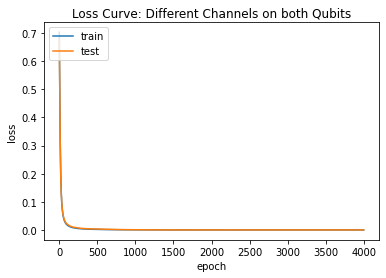

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
score = model.evaluate(x_test,  y_test, verbose=2)

35/35 - 0s - loss: 1.3277e-05 - 208ms/epoch - 6ms/step


In [56]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_both_inf = tf.math.reduce_mean(fid)
print(fid_both_inf)

tf.Tensor((1.0004214+4.6387863e-06j), shape=(), dtype=complex64)


### <font color='red'>Same Channel on both Qubits</font>

In [58]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [59]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [60]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [62]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[900:1200]
y_val_list = vectors_noise_free[900:1200]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1200:]
y_test_list = vectors_noise_free[1200:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [63]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [64]:
# Compile model
adam_opt = tf.optimizers.Adam(0.00018)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [65]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=5000)

Epoch 1/5000
8/8 [==============================] - 1s 40ms/step - loss: 0.7494 - val_loss: 0.7481
Epoch 2/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.7214 - val_loss: 0.7216
Epoch 3/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.6939 - val_loss: 0.6946
Epoch 4/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.6655 - val_loss: 0.6669
Epoch 5/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.6367 - val_loss: 0.6375
Epoch 6/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.6056 - val_loss: 0.6070
Epoch 7/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.5733 - val_loss: 0.5747
Epoch 8/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.5394 - val_loss: 0.5408
Epoch 9/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.5041 - val_loss: 0.5065
Epoch 10/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.4689 - val_loss: 0.4727
Epoch 11/5

8/8 [==============================] - 0s 14ms/step - loss: 0.0296 - val_loss: 0.0365
Epoch 84/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0290 - val_loss: 0.0358
Epoch 85/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0285 - val_loss: 0.0352
Epoch 86/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0280 - val_loss: 0.0346
Epoch 87/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0275 - val_loss: 0.0341
Epoch 88/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0270 - val_loss: 0.0335
Epoch 89/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0266 - val_loss: 0.0330
Epoch 90/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0261 - val_loss: 0.0325
Epoch 91/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0257 - val_loss: 0.0320
Epoch 92/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0315
Epoch 93/5000
8

8/8 [==============================] - 0s 12ms/step - loss: 0.0109 - val_loss: 0.0143
Epoch 165/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0143
Epoch 166/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0107 - val_loss: 0.0141
Epoch 167/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0106 - val_loss: 0.0140
Epoch 168/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0139
Epoch 169/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0105 - val_loss: 0.0138
Epoch 170/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0137
Epoch 171/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0103 - val_loss: 0.0136
Epoch 172/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 173/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0134
Epoch

8/8 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 246/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0061 - val_loss: 0.0083
Epoch 247/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 248/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 249/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0082
Epoch 250/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0081
Epoch 251/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0059 - val_loss: 0.0081
Epoch 252/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 253/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 254/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0079
Epoch

8/8 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 327/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 328/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 329/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 330/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 331/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 332/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 333/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 334/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 335/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 3

8/8 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 408/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 409/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 410/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 411/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 412/5000
8/8 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 413/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 414/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 415/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 416/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch

8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 489/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 490/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 491/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 492/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 493/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 494/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 495/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 496/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 497/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4

8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 570/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 571/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 572/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 573/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 574/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 575/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 576/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 577/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 578/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 57

8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 651/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 652/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 653/5000
8/8 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 654/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 655/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 656/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 657/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 658/5000
8/8 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 659/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch

8/8 [==============================] - 0s 10ms/step - loss: 8.1738e-04 - val_loss: 0.0013
Epoch 730/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.1616e-04 - val_loss: 0.0013
Epoch 731/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.0804e-04 - val_loss: 0.0013
Epoch 732/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.0971e-04 - val_loss: 0.0013
Epoch 733/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.0539e-04 - val_loss: 0.0013
Epoch 734/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9922e-04 - val_loss: 0.0013
Epoch 735/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9884e-04 - val_loss: 0.0013
Epoch 736/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.9428e-04 - val_loss: 0.0013
Epoch 737/5000
8/8 [==============================] - 0s 15ms/step - loss: 7.9016e-04 - val_loss: 0.0013
Epoch 738/5000
8/8 [==============================] - 0s 16ms/step - loss

8/8 [==============================] - 0s 12ms/step - loss: 5.9379e-04 - val_loss: 9.7440e-04
Epoch 808/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.8611e-04 - val_loss: 9.6937e-04
Epoch 809/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.8505e-04 - val_loss: 9.7296e-04
Epoch 810/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.7986e-04 - val_loss: 9.6343e-04
Epoch 811/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.8252e-04 - val_loss: 9.5465e-04
Epoch 812/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.8045e-04 - val_loss: 9.6670e-04
Epoch 813/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.7714e-04 - val_loss: 9.5606e-04
Epoch 814/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.7684e-04 - val_loss: 9.5184e-04
Epoch 815/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.7062e-04 - val_loss: 9.4599e-04
Epoch 816/5000
8/8 [================

8/8 [==============================] - 0s 10ms/step - loss: 4.2978e-04 - val_loss: 7.3843e-04
Epoch 883/5000
8/8 [==============================] - 0s 17ms/step - loss: 4.2709e-04 - val_loss: 7.3350e-04
Epoch 884/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.2760e-04 - val_loss: 7.2872e-04
Epoch 885/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.2484e-04 - val_loss: 7.2254e-04
Epoch 886/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.1919e-04 - val_loss: 7.1881e-04
Epoch 887/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.1624e-04 - val_loss: 7.1398e-04
Epoch 888/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.1631e-04 - val_loss: 7.1101e-04
Epoch 889/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.1305e-04 - val_loss: 7.0467e-04
Epoch 890/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.0963e-04 - val_loss: 6.9964e-04
Epoch 891/5000
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 2.9324e-04 - val_loss: 5.2910e-04
Epoch 958/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.9201e-04 - val_loss: 5.1795e-04
Epoch 959/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.9095e-04 - val_loss: 5.1903e-04
Epoch 960/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.9271e-04 - val_loss: 5.2024e-04
Epoch 961/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.9100e-04 - val_loss: 5.1789e-04
Epoch 962/5000
8/8 [==============================] - 0s 15ms/step - loss: 2.8694e-04 - val_loss: 5.1147e-04
Epoch 963/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.8357e-04 - val_loss: 5.1558e-04
Epoch 964/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8508e-04 - val_loss: 5.0598e-04
Epoch 965/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.8122e-04 - val_loss: 5.0268e-04
Epoch 966/5000
8/8 [==================

8/8 [==============================] - 0s 10ms/step - loss: 1.9245e-04 - val_loss: 3.6721e-04
Epoch 1033/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.9370e-04 - val_loss: 3.6440e-04
Epoch 1034/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9222e-04 - val_loss: 3.6452e-04
Epoch 1035/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.8942e-04 - val_loss: 3.6263e-04
Epoch 1036/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8871e-04 - val_loss: 3.6448e-04
Epoch 1037/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.8799e-04 - val_loss: 3.5800e-04
Epoch 1038/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8646e-04 - val_loss: 3.5515e-04
Epoch 1039/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.8593e-04 - val_loss: 3.5993e-04
Epoch 1040/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.8589e-04 - val_loss: 3.5732e-04
Epoch 1041/5000
8/8 [=======

Epoch 1107/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2290e-04 - val_loss: 2.4137e-04
Epoch 1108/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.2011e-04 - val_loss: 2.4080e-04
Epoch 1109/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1932e-04 - val_loss: 2.3961e-04
Epoch 1110/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.1801e-04 - val_loss: 2.3520e-04
Epoch 1111/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.1766e-04 - val_loss: 2.3618e-04
Epoch 1112/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1614e-04 - val_loss: 2.3440e-04
Epoch 1113/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1657e-04 - val_loss: 2.3493e-04
Epoch 1114/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1541e-04 - val_loss: 2.3215e-04
Epoch 1115/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1470e-04 - val_loss: 2.3351e-04
Epoch 1116/50

Epoch 1182/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.3282e-05 - val_loss: 1.5492e-04
Epoch 1183/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.2778e-05 - val_loss: 1.5741e-04
Epoch 1184/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.4197e-05 - val_loss: 1.5878e-04
Epoch 1185/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.3782e-05 - val_loss: 1.5519e-04
Epoch 1186/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.2106e-05 - val_loss: 1.5015e-04
Epoch 1187/5000
8/8 [==============================] - 0s 14ms/step - loss: 6.9399e-05 - val_loss: 1.5048e-04
Epoch 1188/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.9094e-05 - val_loss: 1.4952e-04
Epoch 1189/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9799e-05 - val_loss: 1.4870e-04
Epoch 1190/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7269e-05 - val_loss: 1.4621e-04
Epoch 1191/5000


Epoch 1257/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9870e-05 - val_loss: 9.2221e-05
Epoch 1258/5000
8/8 [==============================] - 0s 14ms/step - loss: 3.9476e-05 - val_loss: 9.3073e-05
Epoch 1259/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.9403e-05 - val_loss: 9.2243e-05
Epoch 1260/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.8447e-05 - val_loss: 9.0836e-05
Epoch 1261/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.8245e-05 - val_loss: 8.9844e-05
Epoch 1262/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.8167e-05 - val_loss: 8.8011e-05
Epoch 1263/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.7126e-05 - val_loss: 8.7656e-05
Epoch 1264/5000
8/8 [==============================] - 0s 14ms/step - loss: 3.7127e-05 - val_loss: 8.7260e-05
Epoch 1265/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.6855e-05 - val_loss: 8.5678e-05
Epoch 1266/5

Epoch 1332/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0930e-05 - val_loss: 5.5539e-05
Epoch 1333/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.0576e-05 - val_loss: 5.5414e-05
Epoch 1334/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.1162e-05 - val_loss: 5.5541e-05
Epoch 1335/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.1495e-05 - val_loss: 5.6150e-05
Epoch 1336/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.0968e-05 - val_loss: 5.6128e-05
Epoch 1337/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0805e-05 - val_loss: 5.5012e-05
Epoch 1338/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.0779e-05 - val_loss: 5.4642e-05
Epoch 1339/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9778e-05 - val_loss: 5.3680e-05
Epoch 1340/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9729e-05 - val_loss: 5.3379e-05
Epoch 1341/50

Epoch 1407/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.2315e-05 - val_loss: 3.9355e-05
Epoch 1408/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.2354e-05 - val_loss: 3.9151e-05
Epoch 1409/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.2240e-05 - val_loss: 4.0108e-05
Epoch 1410/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2392e-05 - val_loss: 3.8503e-05
Epoch 1411/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2326e-05 - val_loss: 3.9493e-05
Epoch 1412/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2269e-05 - val_loss: 3.8719e-05
Epoch 1413/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1790e-05 - val_loss: 3.8108e-05
Epoch 1414/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1704e-05 - val_loss: 3.8787e-05
Epoch 1415/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1795e-05 - val_loss: 3.7788e-05
Epoch 1416/5

Epoch 1482/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.4690e-06 - val_loss: 2.7864e-05
Epoch 1483/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.2056e-06 - val_loss: 2.8050e-05
Epoch 1484/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.2043e-06 - val_loss: 2.7728e-05
Epoch 1485/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.3325e-06 - val_loss: 2.8120e-05
Epoch 1486/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.4878e-06 - val_loss: 2.6906e-05
Epoch 1487/5000
8/8 [==============================] - 0s 13ms/step - loss: 7.0579e-06 - val_loss: 2.7021e-05
Epoch 1488/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7797e-06 - val_loss: 2.7370e-05
Epoch 1489/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.8933e-06 - val_loss: 2.6633e-05
Epoch 1490/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7142e-06 - val_loss: 2.6900e-05
Epoch 1491/5000
8

Epoch 1557/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.6720e-06 - val_loss: 2.0978e-05
Epoch 1558/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.3783e-06 - val_loss: 2.0304e-05
Epoch 1559/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.2326e-06 - val_loss: 2.0688e-05
Epoch 1560/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.5939e-06 - val_loss: 2.0447e-05
Epoch 1561/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.4174e-06 - val_loss: 2.0523e-05
Epoch 1562/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.3910e-06 - val_loss: 2.0368e-05
Epoch 1563/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.3301e-06 - val_loss: 2.0715e-05
Epoch 1564/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.4563e-06 - val_loss: 2.0761e-05
Epoch 1565/5000
8/8 [==============================] - 0s 14ms/step - loss: 4.3637e-06 - val_loss: 2.0057e-05
Epoch 1566/50

Epoch 1632/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.1573e-06 - val_loss: 1.6607e-05
Epoch 1633/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.1882e-06 - val_loss: 1.7381e-05
Epoch 1634/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.5537e-06 - val_loss: 1.7175e-05
Epoch 1635/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.9427e-06 - val_loss: 1.6874e-05
Epoch 1636/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.5889e-06 - val_loss: 1.6699e-05
Epoch 1637/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.1491e-06 - val_loss: 1.6653e-05
Epoch 1638/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.1354e-06 - val_loss: 1.7435e-05
Epoch 1639/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.3284e-06 - val_loss: 1.6647e-05
Epoch 1640/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.1735e-06 - val_loss: 1.6603e-05
Epoch 1641/5

8/8 [==============================] - 0s 10ms/step - loss: 2.0903e-06 - val_loss: 1.3535e-05
Epoch 1707/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2571e-06 - val_loss: 1.3370e-05
Epoch 1708/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.3779e-06 - val_loss: 1.3933e-05
Epoch 1709/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3636e-06 - val_loss: 1.4030e-05
Epoch 1710/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.6573e-06 - val_loss: 1.4278e-05
Epoch 1711/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.5956e-06 - val_loss: 1.3563e-05
Epoch 1712/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.3089e-06 - val_loss: 1.3565e-05
Epoch 1713/5000
8/8 [==============================] - 0s 14ms/step - loss: 2.0740e-06 - val_loss: 1.3364e-05
Epoch 1714/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.0570e-06 - val_loss: 1.3509e-05
Epoch 1715/5000
8/8 [=======

Epoch 1781/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1225e-06 - val_loss: 1.1987e-05
Epoch 1782/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.7796e-06 - val_loss: 1.1663e-05
Epoch 1783/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.5541e-06 - val_loss: 1.1611e-05
Epoch 1784/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7674e-06 - val_loss: 1.1952e-05
Epoch 1785/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6532e-06 - val_loss: 1.1403e-05
Epoch 1786/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2739e-06 - val_loss: 1.1169e-05
Epoch 1787/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3523e-06 - val_loss: 1.1506e-05
Epoch 1788/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.4292e-06 - val_loss: 1.1661e-05
Epoch 1789/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4990e-06 - val_loss: 1.1242e-05
Epoch 1790/5000


Epoch 1856/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.4324e-06 - val_loss: 1.0855e-05
Epoch 1857/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.8713e-06 - val_loss: 1.0616e-05
Epoch 1858/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.4402e-06 - val_loss: 1.0543e-05
Epoch 1859/5000
8/8 [==============================] - 0s 15ms/step - loss: 1.4812e-06 - val_loss: 1.0316e-05
Epoch 1860/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.5385e-06 - val_loss: 1.0145e-05
Epoch 1861/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.9754e-06 - val_loss: 1.0757e-05
Epoch 1862/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9608e-06 - val_loss: 1.1557e-05
Epoch 1863/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8655e-06 - val_loss: 1.0041e-05
Epoch 1864/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2868e-06 - val_loss: 9.8415e-06
Epoch 1865/

Epoch 1931/5000
8/8 [==============================] - 0s 14ms/step - loss: 9.8862e-07 - val_loss: 9.4535e-06
Epoch 1932/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1317e-06 - val_loss: 8.9002e-06
Epoch 1933/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.4585e-07 - val_loss: 8.8354e-06
Epoch 1934/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.7067e-07 - val_loss: 8.7619e-06
Epoch 1935/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3460e-07 - val_loss: 8.8491e-06
Epoch 1936/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.2978e-07 - val_loss: 8.7464e-06
Epoch 1937/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.4112e-07 - val_loss: 8.7130e-06
Epoch 1938/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.2093e-07 - val_loss: 8.6157e-06
Epoch 1939/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.3688e-07 - val_loss: 8.6153e-06
Epoch 1940/500

Epoch 2006/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4161e-06 - val_loss: 1.0172e-05
Epoch 2007/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.5016e-06 - val_loss: 1.0073e-05
Epoch 2008/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.8839e-06 - val_loss: 1.5735e-05
Epoch 2009/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.8882e-06 - val_loss: 1.3827e-05
Epoch 2010/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.8022e-06 - val_loss: 9.0688e-06
Epoch 2011/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.6584e-06 - val_loss: 9.6742e-06
Epoch 2012/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8111e-06 - val_loss: 9.0478e-06
Epoch 2013/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0522e-06 - val_loss: 8.4080e-06
Epoch 2014/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.0049e-07 - val_loss: 8.1958e-06
Epoch 2015/5000

Epoch 2081/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3415e-07 - val_loss: 8.0512e-06
Epoch 2082/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.2098e-07 - val_loss: 8.1346e-06
Epoch 2083/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.7433e-07 - val_loss: 8.0081e-06
Epoch 2084/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.3211e-07 - val_loss: 7.9759e-06
Epoch 2085/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.7590e-07 - val_loss: 8.3013e-06
Epoch 2086/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.6144e-07 - val_loss: 8.1603e-06
Epoch 2087/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.9921e-07 - val_loss: 7.6675e-06
Epoch 2088/5000
8/8 [==============================] - 0s 14ms/step - loss: 6.5528e-07 - val_loss: 7.8879e-06
Epoch 2089/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.0087e-06 - val_loss: 8.3848e-06
Epoch 2090/500

Epoch 2156/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.2311e-07 - val_loss: 7.3856e-06
Epoch 2157/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.7401e-07 - val_loss: 7.2028e-06
Epoch 2158/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.2162e-07 - val_loss: 7.5175e-06
Epoch 2159/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.3339e-07 - val_loss: 7.6133e-06
Epoch 2160/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.1035e-07 - val_loss: 8.0675e-06
Epoch 2161/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.0994e-07 - val_loss: 7.8183e-06
Epoch 2162/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.0110e-07 - val_loss: 7.8593e-06
Epoch 2163/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.1241e-07 - val_loss: 7.7772e-06
Epoch 2164/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2433e-06 - val_loss: 8.5501e-06
Epoch 2165/5000


Epoch 2231/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.8616e-07 - val_loss: 6.9517e-06
Epoch 2232/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.9652e-07 - val_loss: 7.0186e-06
Epoch 2233/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.1433e-07 - val_loss: 7.0560e-06
Epoch 2234/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.0069e-07 - val_loss: 7.0725e-06
Epoch 2235/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.3598e-07 - val_loss: 7.6083e-06
Epoch 2236/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.1860e-07 - val_loss: 7.2362e-06
Epoch 2237/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9693e-07 - val_loss: 7.3918e-06
Epoch 2238/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.3059e-07 - val_loss: 7.8479e-06
Epoch 2239/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.3769e-06 - val_loss: 1.0536e-05
Epoch 2240/50

Epoch 2306/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.2695e-07 - val_loss: 7.5050e-06
Epoch 2307/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7621e-07 - val_loss: 7.5201e-06
Epoch 2308/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9527e-07 - val_loss: 7.2060e-06
Epoch 2309/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.2128e-07 - val_loss: 7.2545e-06
Epoch 2310/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.3409e-07 - val_loss: 7.4911e-06
Epoch 2311/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.7348e-07 - val_loss: 6.8873e-06
Epoch 2312/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.0479e-07 - val_loss: 6.9505e-06
Epoch 2313/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.5903e-07 - val_loss: 7.5080e-06
Epoch 2314/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.5595e-07 - val_loss: 7.1279e-06
Epoch 2315/50

Epoch 2381/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.7870e-07 - val_loss: 7.1053e-06
Epoch 2382/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9898e-07 - val_loss: 6.9495e-06
Epoch 2383/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.2833e-07 - val_loss: 6.9056e-06
Epoch 2384/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.9251e-07 - val_loss: 6.8170e-06
Epoch 2385/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.1486e-07 - val_loss: 6.9217e-06
Epoch 2386/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1194e-07 - val_loss: 7.1836e-06
Epoch 2387/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.2041e-07 - val_loss: 7.1071e-06
Epoch 2388/5000
8/8 [==============================] - 0s 15ms/step - loss: 8.8595e-07 - val_loss: 7.7625e-06
Epoch 2389/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.0223e-07 - val_loss: 6.9988e-06
Epoch 2390/50

Epoch 2456/5000
8/8 [==============================] - 0s 14ms/step - loss: 4.6507e-07 - val_loss: 6.8357e-06
Epoch 2457/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.9229e-07 - val_loss: 6.8798e-06
Epoch 2458/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.3514e-07 - val_loss: 6.8110e-06
Epoch 2459/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.3142e-07 - val_loss: 6.9497e-06
Epoch 2460/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1559e-07 - val_loss: 6.9157e-06
Epoch 2461/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5990e-07 - val_loss: 7.1939e-06
Epoch 2462/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.5365e-06 - val_loss: 8.2914e-06
Epoch 2463/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1601e-06 - val_loss: 7.8307e-06
Epoch 2464/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.4995e-07 - val_loss: 7.8215e-06
Epoch 2465/500

8/8 [==============================] - 0s 13ms/step - loss: 1.2361e-07 - val_loss: 6.6741e-06
Epoch 2531/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6756e-07 - val_loss: 6.7347e-06
Epoch 2532/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.5438e-07 - val_loss: 6.6978e-06
Epoch 2533/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.4775e-07 - val_loss: 6.6745e-06
Epoch 2534/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.4594e-07 - val_loss: 6.9171e-06
Epoch 2535/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.3130e-07 - val_loss: 7.8307e-06
Epoch 2536/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.5124e-07 - val_loss: 7.1015e-06
Epoch 2537/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.9996e-07 - val_loss: 6.8448e-06
Epoch 2538/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.3312e-07 - val_loss: 7.6129e-06
Epoch 2539/5000
8/8 [=========

Epoch 2605/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.6166e-07 - val_loss: 7.8191e-06
Epoch 2606/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.9304e-07 - val_loss: 7.1051e-06
Epoch 2607/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5722e-07 - val_loss: 7.6803e-06
Epoch 2608/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0284e-07 - val_loss: 7.0228e-06
Epoch 2609/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3872e-07 - val_loss: 6.9781e-06
Epoch 2610/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.1443e-07 - val_loss: 6.8645e-06
Epoch 2611/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7054e-07 - val_loss: 6.9261e-06
Epoch 2612/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.8828e-07 - val_loss: 6.8599e-06
Epoch 2613/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.7062e-07 - val_loss: 6.8164e-06
Epoch 2614/5000

Epoch 2680/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.0491e-06 - val_loss: 8.7672e-06
Epoch 2681/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1049e-06 - val_loss: 8.8437e-06
Epoch 2682/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.5868e-06 - val_loss: 7.4220e-06
Epoch 2683/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.3501e-07 - val_loss: 7.4138e-06
Epoch 2684/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.1291e-07 - val_loss: 7.2451e-06
Epoch 2685/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9257e-07 - val_loss: 7.1166e-06
Epoch 2686/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.3482e-07 - val_loss: 7.0783e-06
Epoch 2687/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.5211e-07 - val_loss: 7.1152e-06
Epoch 2688/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.8832e-07 - val_loss: 7.1079e-06
Epoch 2689/500

8/8 [==============================] - 0s 9ms/step - loss: 6.2816e-07 - val_loss: 7.6028e-06
Epoch 2755/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.0692e-07 - val_loss: 7.4701e-06
Epoch 2756/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.3837e-07 - val_loss: 7.3071e-06
Epoch 2757/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3840e-07 - val_loss: 7.4168e-06
Epoch 2758/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.1580e-07 - val_loss: 7.3739e-06
Epoch 2759/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.5225e-07 - val_loss: 7.0204e-06
Epoch 2760/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.6418e-07 - val_loss: 7.2517e-06
Epoch 2761/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.1285e-07 - val_loss: 7.0500e-06
Epoch 2762/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9968e-07 - val_loss: 6.9298e-06
Epoch 2763/5000
8/8 [=============

8/8 [==============================] - 0s 9ms/step - loss: 4.1448e-07 - val_loss: 7.1587e-06
Epoch 2830/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.6031e-07 - val_loss: 7.1228e-06
Epoch 2831/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2589e-07 - val_loss: 7.4579e-06
Epoch 2832/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.0725e-07 - val_loss: 7.3739e-06
Epoch 2833/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2961e-07 - val_loss: 7.2968e-06
Epoch 2834/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.9637e-07 - val_loss: 7.0214e-06
Epoch 2835/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.3272e-07 - val_loss: 7.7627e-06
Epoch 2836/5000
8/8 [==============================] - 0s 14ms/step - loss: 6.1877e-07 - val_loss: 8.0371e-06
Epoch 2837/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.2217e-07 - val_loss: 7.5132e-06
Epoch 2838/5000
8/8 [==========

Epoch 2904/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.0921e-07 - val_loss: 7.6739e-06
Epoch 2905/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.1296e-07 - val_loss: 7.4844e-06
Epoch 2906/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.0017e-07 - val_loss: 7.3808e-06
Epoch 2907/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.5658e-07 - val_loss: 7.3683e-06
Epoch 2908/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.0554e-07 - val_loss: 7.3522e-06
Epoch 2909/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.8190e-07 - val_loss: 7.1337e-06
Epoch 2910/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.9297e-07 - val_loss: 7.1557e-06
Epoch 2911/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.8276e-07 - val_loss: 7.0016e-06
Epoch 2912/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.7657e-07 - val_loss: 7.1688e-06
Epoch 2913/5

Epoch 2979/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8280e-06 - val_loss: 7.7806e-06
Epoch 2980/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.4385e-06 - val_loss: 7.7663e-06
Epoch 2981/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.5901e-06 - val_loss: 1.1408e-05
Epoch 2982/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.5536e-06 - val_loss: 9.4843e-06
Epoch 2983/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.9964e-06 - val_loss: 1.1844e-05
Epoch 2984/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.8965e-06 - val_loss: 9.6027e-06
Epoch 2985/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6893e-06 - val_loss: 8.0528e-06
Epoch 2986/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2644e-06 - val_loss: 8.7241e-06
Epoch 2987/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.4154e-07 - val_loss: 7.5124e-06
Epoch 2988/500

Epoch 3054/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.1228e-08 - val_loss: 6.8619e-06
Epoch 3055/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1325e-07 - val_loss: 6.9112e-06
Epoch 3056/5000
8/8 [==============================] - 0s 12ms/step - loss: 8.1584e-08 - val_loss: 6.8647e-06
Epoch 3057/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.3372e-08 - val_loss: 6.8527e-06
Epoch 3058/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.2478e-08 - val_loss: 6.8754e-06
Epoch 3059/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.4266e-08 - val_loss: 6.8984e-06
Epoch 3060/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0855e-07 - val_loss: 6.8885e-06
Epoch 3061/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0066e-07 - val_loss: 6.8261e-06
Epoch 3062/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0490e-07 - val_loss: 6.8839e-06
Epoch 3063/5000


Epoch 3129/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.8714e-07 - val_loss: 7.5255e-06
Epoch 3130/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.4035e-07 - val_loss: 7.8517e-06
Epoch 3131/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.9336e-07 - val_loss: 7.4071e-06
Epoch 3132/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.2697e-07 - val_loss: 7.9286e-06
Epoch 3133/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.7572e-06 - val_loss: 1.0227e-05
Epoch 3134/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.8738e-06 - val_loss: 9.8042e-06
Epoch 3135/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.2024e-06 - val_loss: 8.1529e-06
Epoch 3136/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.7549e-06 - val_loss: 8.4587e-06
Epoch 3137/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.2903e-06 - val_loss: 8.4037e-06
Epoch 3138

Epoch 3204/5000
8/8 [==============================] - 0s 14ms/step - loss: 5.9463e-07 - val_loss: 7.0192e-06
Epoch 3205/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.0980e-07 - val_loss: 7.1190e-06
Epoch 3206/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.0078e-07 - val_loss: 7.0719e-06
Epoch 3207/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.0556e-07 - val_loss: 6.9918e-06
Epoch 3208/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3605e-07 - val_loss: 6.9485e-06
Epoch 3209/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3344e-07 - val_loss: 6.9149e-06
Epoch 3210/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3404e-07 - val_loss: 6.9231e-06
Epoch 3211/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1168e-07 - val_loss: 6.8688e-06
Epoch 3212/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3612e-07 - val_loss: 6.9602e-06
Epoch 3213/500

Epoch 3279/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.7487e-07 - val_loss: 7.0016e-06
Epoch 3280/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0721e-07 - val_loss: 6.9706e-06
Epoch 3281/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0788e-07 - val_loss: 6.9127e-06
Epoch 3282/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.2055e-07 - val_loss: 6.9928e-06
Epoch 3283/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.3761e-07 - val_loss: 7.0103e-06
Epoch 3284/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8589e-07 - val_loss: 7.2434e-06
Epoch 3285/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.5682e-07 - val_loss: 7.0475e-06
Epoch 3286/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9655e-07 - val_loss: 7.4025e-06
Epoch 3287/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.3483e-07 - val_loss: 7.0572e-06
Epoch 3288/5000

Epoch 3354/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.7721e-07 - val_loss: 7.9429e-06
Epoch 3355/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.4401e-07 - val_loss: 8.0184e-06
Epoch 3356/5000
8/8 [==============================] - 0s 13ms/step - loss: 9.8631e-07 - val_loss: 7.8748e-06
Epoch 3357/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.4215e-07 - val_loss: 7.3967e-06
Epoch 3358/5000
8/8 [==============================] - 0s 14ms/step - loss: 7.8224e-07 - val_loss: 8.6673e-06
Epoch 3359/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0134e-06 - val_loss: 7.1780e-06
Epoch 3360/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.6820e-07 - val_loss: 8.2918e-06
Epoch 3361/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.2591e-07 - val_loss: 7.8279e-06
Epoch 3362/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.2315e-07 - val_loss: 7.4283e-06
Epoch 3363/50

Epoch 3429/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.5533e-07 - val_loss: 7.1458e-06
Epoch 3430/5000
8/8 [==============================] - 0s 15ms/step - loss: 1.8194e-07 - val_loss: 7.1321e-06
Epoch 3431/5000
8/8 [==============================] - 0s 15ms/step - loss: 2.2002e-07 - val_loss: 7.4434e-06
Epoch 3432/5000
8/8 [==============================] - 0s 14ms/step - loss: 3.5383e-07 - val_loss: 7.3787e-06
Epoch 3433/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.4613e-07 - val_loss: 7.2636e-06
Epoch 3434/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.9638e-07 - val_loss: 7.2149e-06
Epoch 3435/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.7325e-07 - val_loss: 7.3646e-06
Epoch 3436/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.9854e-07 - val_loss: 7.4224e-06
Epoch 3437/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.9883e-07 - val_loss: 7.1172e-06
Epoch 3438/

8/8 [==============================] - 0s 12ms/step - loss: 5.2594e-07 - val_loss: 7.6161e-06
Epoch 3504/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.2160e-07 - val_loss: 7.6236e-06
Epoch 3505/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.7995e-07 - val_loss: 7.9477e-06
Epoch 3506/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1821e-06 - val_loss: 9.3077e-06
Epoch 3507/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.5037e-06 - val_loss: 7.6737e-06
Epoch 3508/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0324e-06 - val_loss: 7.7158e-06
Epoch 3509/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.2092e-07 - val_loss: 8.5433e-06
Epoch 3510/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3363e-07 - val_loss: 9.1285e-06
Epoch 3511/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.1128e-06 - val_loss: 9.8715e-06
Epoch 3512/5000
8/8 [========

Epoch 3578/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.8096e-06 - val_loss: 9.6923e-06
Epoch 3579/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.4184e-06 - val_loss: 7.9600e-06
Epoch 3580/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.0592e-06 - val_loss: 8.5398e-06
Epoch 3581/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.8434e-06 - val_loss: 9.7261e-06
Epoch 3582/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.6266e-06 - val_loss: 7.9844e-06
Epoch 3583/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3697e-06 - val_loss: 8.2213e-06
Epoch 3584/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4974e-06 - val_loss: 8.7585e-06
Epoch 3585/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.5520e-06 - val_loss: 9.0226e-06
Epoch 3586/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.3579e-06 - val_loss: 7.9087e-06
Epoch 3587/500

Epoch 3653/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3102e-07 - val_loss: 9.3349e-06
Epoch 3654/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9505e-07 - val_loss: 7.6274e-06
Epoch 3655/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.2288e-07 - val_loss: 7.5740e-06
Epoch 3656/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.7405e-07 - val_loss: 7.6586e-06
Epoch 3657/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.9935e-07 - val_loss: 7.6491e-06
Epoch 3658/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.0904e-07 - val_loss: 7.7333e-06
Epoch 3659/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.9084e-07 - val_loss: 7.6979e-06
Epoch 3660/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2134e-07 - val_loss: 7.8521e-06
Epoch 3661/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.6657e-07 - val_loss: 7.6197e-06
Epoch 3662/500

8/8 [==============================] - 0s 9ms/step - loss: 2.9154e-07 - val_loss: 7.5640e-06
Epoch 3728/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8357e-07 - val_loss: 7.5316e-06
Epoch 3729/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8707e-07 - val_loss: 7.7826e-06
Epoch 3730/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.9672e-07 - val_loss: 7.9503e-06
Epoch 3731/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.9678e-07 - val_loss: 7.7146e-06
Epoch 3732/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.3450e-07 - val_loss: 8.1120e-06
Epoch 3733/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.6475e-07 - val_loss: 7.4075e-06
Epoch 3734/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.1732e-07 - val_loss: 7.6437e-06
Epoch 3735/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.4995e-07 - val_loss: 7.8851e-06
Epoch 3736/5000
8/8 [=============

Epoch 3802/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0818e-07 - val_loss: 7.3582e-06
Epoch 3803/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.1733e-08 - val_loss: 7.3967e-06
Epoch 3804/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.4878e-08 - val_loss: 7.4106e-06
Epoch 3805/5000
8/8 [==============================] - 0s 11ms/step - loss: 8.6725e-08 - val_loss: 7.3906e-06
Epoch 3806/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.3761e-08 - val_loss: 7.3924e-06
Epoch 3807/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.3702e-08 - val_loss: 7.3969e-06
Epoch 3808/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.1989e-08 - val_loss: 7.3973e-06
Epoch 3809/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.0648e-08 - val_loss: 7.3349e-06
Epoch 3810/5000
8/8 [==============================] - 0s 14ms/step - loss: 5.4613e-08 - val_loss: 7.3479e-06
Epoch 3811/50

Epoch 3877/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6630e-07 - val_loss: 7.4573e-06
Epoch 3878/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.4775e-07 - val_loss: 7.4669e-06
Epoch 3879/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6287e-07 - val_loss: 7.3930e-06
Epoch 3880/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1093e-07 - val_loss: 7.6958e-06
Epoch 3881/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0288e-07 - val_loss: 7.5493e-06
Epoch 3882/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.7841e-07 - val_loss: 7.6296e-06
Epoch 3883/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5103e-07 - val_loss: 7.9811e-06
Epoch 3884/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.0883e-06 - val_loss: 1.0846e-05
Epoch 3885/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.7447e-06 - val_loss: 9.7378e-06
Epoch 3886/5000
8

Epoch 3952/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.5474e-07 - val_loss: 7.6145e-06
Epoch 3953/5000
8/8 [==============================] - 0s 14ms/step - loss: 4.7155e-07 - val_loss: 7.5817e-06
Epoch 3954/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.3510e-07 - val_loss: 7.6356e-06
Epoch 3955/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1832e-06 - val_loss: 8.6768e-06
Epoch 3956/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6521e-06 - val_loss: 1.0458e-05
Epoch 3957/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.4295e-06 - val_loss: 8.1489e-06
Epoch 3958/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.8467e-07 - val_loss: 8.0663e-06
Epoch 3959/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.1549e-06 - val_loss: 8.0675e-06
Epoch 3960/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2936e-06 - val_loss: 8.0935e-06
Epoch 3961/5

Epoch 4027/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.5492e-06 - val_loss: 9.3693e-06
Epoch 4028/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.4552e-06 - val_loss: 8.4428e-06
Epoch 4029/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.3557e-06 - val_loss: 9.8209e-06
Epoch 4030/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3868e-06 - val_loss: 9.2405e-06
Epoch 4031/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6116e-06 - val_loss: 9.0474e-06
Epoch 4032/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4441e-06 - val_loss: 8.3540e-06
Epoch 4033/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1438e-06 - val_loss: 7.8394e-06
Epoch 4034/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.6191e-07 - val_loss: 8.3534e-06
Epoch 4035/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.9630e-07 - val_loss: 8.2300e-06
Epoch 4036/5000


Epoch 4102/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0536e-06 - val_loss: 9.4815e-06
Epoch 4103/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.4751e-06 - val_loss: 8.9975e-06
Epoch 4104/5000
8/8 [==============================] - 0s 11ms/step - loss: 9.2939e-07 - val_loss: 7.8285e-06
Epoch 4105/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7823e-07 - val_loss: 7.8605e-06
Epoch 4106/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6176e-06 - val_loss: 8.3552e-06
Epoch 4107/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.9396e-07 - val_loss: 7.9360e-06
Epoch 4108/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.9600e-07 - val_loss: 7.6983e-06
Epoch 4109/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2292e-07 - val_loss: 7.6809e-06
Epoch 4110/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9714e-07 - val_loss: 7.6075e-06
Epoch 4111/5000


Epoch 4177/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.4064e-07 - val_loss: 7.6210e-06
Epoch 4178/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3514e-07 - val_loss: 7.7260e-06
Epoch 4179/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.9683e-07 - val_loss: 7.8811e-06
Epoch 4180/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1008e-07 - val_loss: 7.7468e-06
Epoch 4181/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.9220e-07 - val_loss: 7.9699e-06
Epoch 4182/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.1871e-07 - val_loss: 7.7486e-06
Epoch 4183/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.6073e-07 - val_loss: 8.5008e-06
Epoch 4184/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.2276e-06 - val_loss: 8.3206e-06
Epoch 4185/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0996e-06 - val_loss: 1.0001e-05
Epoch 4186/50

Epoch 4252/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.7278e-07 - val_loss: 7.6447e-06
Epoch 4253/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.1175e-07 - val_loss: 7.5652e-06
Epoch 4254/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0832e-07 - val_loss: 7.7430e-06
Epoch 4255/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.7582e-07 - val_loss: 7.6054e-06
Epoch 4256/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.4730e-07 - val_loss: 7.6491e-06
Epoch 4257/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8261e-07 - val_loss: 7.6222e-06
Epoch 4258/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6019e-07 - val_loss: 7.6222e-06
Epoch 4259/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.6688e-07 - val_loss: 7.8132e-06
Epoch 4260/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7144e-07 - val_loss: 7.5136e-06
Epoch 4261/5000

Epoch 4327/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.6729e-06 - val_loss: 1.0254e-05
Epoch 4328/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.8025e-06 - val_loss: 8.6480e-06
Epoch 4329/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.4536e-07 - val_loss: 8.3131e-06
Epoch 4330/5000
8/8 [==============================] - 0s 12ms/step - loss: 7.0013e-07 - val_loss: 8.0856e-06
Epoch 4331/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1686e-07 - val_loss: 7.8330e-06
Epoch 4332/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.1702e-07 - val_loss: 7.9268e-06
Epoch 4333/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.6299e-07 - val_loss: 7.8426e-06
Epoch 4334/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9786e-07 - val_loss: 7.8019e-06
Epoch 4335/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.5367e-07 - val_loss: 8.1289e-06
Epoch 4336/500

Epoch 4402/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0981e-07 - val_loss: 7.7963e-06
Epoch 4403/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.2195e-07 - val_loss: 7.6441e-06
Epoch 4404/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2115e-07 - val_loss: 7.5883e-06
Epoch 4405/5000
8/8 [==============================] - 0s 11ms/step - loss: 8.2627e-08 - val_loss: 7.5710e-06
Epoch 4406/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2189e-07 - val_loss: 7.6073e-06
Epoch 4407/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.5527e-07 - val_loss: 7.6715e-06
Epoch 4408/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.5527e-07 - val_loss: 7.6028e-06
Epoch 4409/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2121e-07 - val_loss: 7.9175e-06
Epoch 4410/5000
8/8 [==============================] - 0s 8ms/step - loss: 9.6098e-07 - val_loss: 9.5258e-06
Epoch 4411/500

Epoch 4477/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2009e-07 - val_loss: 7.7436e-06
Epoch 4478/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1146e-07 - val_loss: 7.6793e-06
Epoch 4479/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2271e-07 - val_loss: 7.7208e-06
Epoch 4480/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7375e-07 - val_loss: 7.7323e-06
Epoch 4481/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.8448e-07 - val_loss: 8.1696e-06
Epoch 4482/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.9599e-07 - val_loss: 9.7668e-06
Epoch 4483/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.2686e-06 - val_loss: 1.0119e-05
Epoch 4484/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.4224e-06 - val_loss: 1.0356e-05
Epoch 4485/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.5201e-06 - val_loss: 9.5564e-06
Epoch 4486/5000


Epoch 4552/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.6898e-07 - val_loss: 7.8126e-06
Epoch 4553/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.4149e-07 - val_loss: 7.7665e-06
Epoch 4554/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.4611e-07 - val_loss: 7.7846e-06
Epoch 4555/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.8944e-08 - val_loss: 7.7615e-06
Epoch 4556/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.4788e-08 - val_loss: 7.6663e-06
Epoch 4557/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.6624e-08 - val_loss: 7.6280e-06
Epoch 4558/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.7369e-08 - val_loss: 7.6242e-06
Epoch 4559/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.9397e-08 - val_loss: 7.6048e-06
Epoch 4560/5000
8/8 [==============================] - 0s 14ms/step - loss: 5.3272e-08 - val_loss: 7.6308e-06
Epoch 4561/500

Epoch 4627/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1936e-07 - val_loss: 7.7494e-06
Epoch 4628/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.3686e-08 - val_loss: 7.6884e-06
Epoch 4629/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4149e-07 - val_loss: 7.6928e-06
Epoch 4630/5000
8/8 [==============================] - 0s 11ms/step - loss: 9.8422e-08 - val_loss: 7.7395e-06
Epoch 4631/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.1882e-08 - val_loss: 7.6862e-06
Epoch 4632/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3654e-08 - val_loss: 7.7905e-06
Epoch 4633/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.6240e-07 - val_loss: 8.0007e-06
Epoch 4634/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.8929e-07 - val_loss: 8.6218e-06
Epoch 4635/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.0662e-06 - val_loss: 1.1054e-05
Epoch 4636/5000

Epoch 4702/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.8080e-06 - val_loss: 8.8990e-06
Epoch 4703/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2742e-06 - val_loss: 8.4702e-06
Epoch 4704/5000
8/8 [==============================] - 0s 11ms/step - loss: 8.4996e-07 - val_loss: 8.4823e-06
Epoch 4705/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.1189e-07 - val_loss: 8.6057e-06
Epoch 4706/5000
8/8 [==============================] - 0s 12ms/step - loss: 7.7918e-07 - val_loss: 8.1863e-06
Epoch 4707/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.1507e-07 - val_loss: 8.3411e-06
Epoch 4708/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.8995e-07 - val_loss: 7.9640e-06
Epoch 4709/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.4393e-07 - val_loss: 7.8569e-06
Epoch 4710/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.4833e-07 - val_loss: 7.8805e-06
Epoch 4711/500

Epoch 4777/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.1681e-07 - val_loss: 7.8984e-06
Epoch 4778/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1681e-07 - val_loss: 8.1005e-06
Epoch 4779/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2499e-07 - val_loss: 8.2755e-06
Epoch 4780/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.1834e-07 - val_loss: 8.0778e-06
Epoch 4781/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.6597e-07 - val_loss: 8.1625e-06
Epoch 4782/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.8960e-07 - val_loss: 8.2507e-06
Epoch 4783/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0589e-07 - val_loss: 7.9189e-06
Epoch 4784/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.2014e-07 - val_loss: 7.9469e-06
Epoch 4785/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.4196e-07 - val_loss: 8.8888e-06
Epoch 4786/5000


8/8 [==============================] - 0s 9ms/step - loss: 2.1070e-07 - val_loss: 7.9934e-06
Epoch 4852/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6779e-07 - val_loss: 7.9238e-06
Epoch 4853/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.4953e-07 - val_loss: 7.8475e-06
Epoch 4854/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1869e-07 - val_loss: 7.7589e-06
Epoch 4855/5000
8/8 [==============================] - 0s 12ms/step - loss: 8.7395e-08 - val_loss: 7.7875e-06
Epoch 4856/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9051e-08 - val_loss: 7.7717e-06
Epoch 4857/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5714e-08 - val_loss: 7.7474e-06
Epoch 4858/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.6492e-08 - val_loss: 7.7377e-06
Epoch 4859/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.7891e-08 - val_loss: 7.7651e-06
Epoch 4860/5000
8/8 [===========

Epoch 4926/5000
8/8 [==============================] - 0s 13ms/step - loss: 7.4662e-07 - val_loss: 8.2125e-06
Epoch 4927/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0478e-07 - val_loss: 8.2988e-06
Epoch 4928/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.4426e-07 - val_loss: 8.1335e-06
Epoch 4929/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.9769e-07 - val_loss: 8.4124e-06
Epoch 4930/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.5678e-07 - val_loss: 8.3435e-06
Epoch 4931/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.2088e-07 - val_loss: 8.0156e-06
Epoch 4932/5000
8/8 [==============================] - 0s 17ms/step - loss: 2.6926e-07 - val_loss: 8.0957e-06
Epoch 4933/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.9303e-07 - val_loss: 8.1295e-06
Epoch 4934/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.6082e-07 - val_loss: 8.1887e-06
Epoch 4935/50

8/8 [==============================] - 0s 13ms/step - loss: 8.0988e-08 - val_loss: 7.8621e-06


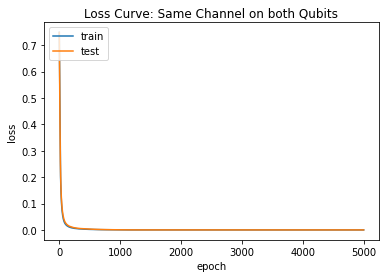

In [66]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
score = model.evaluate(x_test,  y_test, verbose=2)

25/25 - 0s - loss: 1.0578e-05 - 275ms/epoch - 11ms/step


In [68]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_inf = tf.math.reduce_mean(fid)
print(fid_same_inf)

tf.Tensor((1.000423-1.246657e-06j), shape=(), dtype=complex64)


### <font color='red'>One Channel on one Qubit</font>

In [69]:
# Generate data
data = generate_Haar_data(2, 2000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [70]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [71]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [72]:
x_train_list = vectors_with_noise[:800]
y_train_list = vectors_noise_free[:800]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[1800:1900]
y_val_list = vectors_noise_free[1800:1900]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[1900:]
y_test_list = vectors_noise_free[1900:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [73]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [74]:
# Compile model
adam_opt = tf.optimizers.Adam(0.00018)
model.compile(optimizer=adam_opt,
              loss=infidelity)

In [75]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=5000)

Epoch 1/5000
8/8 [==============================] - 1s 42ms/step - loss: 0.7159 - val_loss: 0.7020
Epoch 2/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.6876 - val_loss: 0.6725
Epoch 3/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.6586 - val_loss: 0.6421
Epoch 4/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.6288 - val_loss: 0.6105
Epoch 5/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.5979 - val_loss: 0.5776
Epoch 6/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.5655 - val_loss: 0.5443
Epoch 7/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.5317 - val_loss: 0.5097
Epoch 8/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.4973 - val_loss: 0.4747
Epoch 9/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.4626 - val_loss: 0.4398
Epoch 10/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.4289 - val_loss: 0.4061
Epoch 11/5000
8/8 

8/8 [==============================] - 0s 10ms/step - loss: 0.0263 - val_loss: 0.0299
Epoch 84/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0259 - val_loss: 0.0294
Epoch 85/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0255 - val_loss: 0.0291
Epoch 86/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - val_loss: 0.0286
Epoch 87/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0247 - val_loss: 0.0282
Epoch 88/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0243 - val_loss: 0.0278
Epoch 89/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0239 - val_loss: 0.0274
Epoch 90/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0236 - val_loss: 0.0270
Epoch 91/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0232 - val_loss: 0.0267
Epoch 92/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0229 - val_loss: 0.0263
Epoch 93/5000
8/8

Epoch 165/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0130
Epoch 166/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0129
Epoch 167/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 168/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 169/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 170/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 171/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0098 - val_loss: 0.0124
Epoch 172/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 173/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 174/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0096 - val_loss: 0

8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 247/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 248/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 249/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0079
Epoch 250/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 251/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 252/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0078
Epoch 253/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 254/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 255/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 256

Epoch 328/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 329/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 330/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 331/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 332/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 333/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 334/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 335/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 336/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 337/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 0.005

8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 410/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 411/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 412/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 413/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 414/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 415/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 416/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 417/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 418/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 41

8/8 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 491/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 492/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 493/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 494/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 495/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 496/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 497/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 498/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 499/5000
8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 500

Epoch 572/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 573/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 574/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 575/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 576/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 577/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 578/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 579/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 580/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 581/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.00

8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 654/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 655/5000
8/8 [==============================] - 0s 12ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 656/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 657/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 658/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 659/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 660/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 661/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 662/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 663/500

Epoch 735/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 736/5000
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 737/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 738/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 739/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 740/5000
8/8 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 741/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 742/5000
8/8 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 743/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 744/5000
8/8 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.002

8/8 [==============================] - 0s 12ms/step - loss: 9.3395e-04 - val_loss: 0.0018
Epoch 816/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3068e-04 - val_loss: 0.0018
Epoch 817/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.3270e-04 - val_loss: 0.0018
Epoch 818/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.2449e-04 - val_loss: 0.0018
Epoch 819/5000
8/8 [==============================] - 0s 12ms/step - loss: 9.2471e-04 - val_loss: 0.0018
Epoch 820/5000
8/8 [==============================] - 0s 15ms/step - loss: 9.2446e-04 - val_loss: 0.0018
Epoch 821/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.2112e-04 - val_loss: 0.0018
Epoch 822/5000
8/8 [==============================] - 0s 13ms/step - loss: 9.2091e-04 - val_loss: 0.0018
Epoch 823/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.1607e-04 - val_loss: 0.0018
Epoch 824/5000
8/8 [==============================] - 0s 16ms/step - loss: 

8/8 [==============================] - 0s 9ms/step - loss: 7.8399e-04 - val_loss: 0.0016
Epoch 894/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.8258e-04 - val_loss: 0.0016
Epoch 895/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.7991e-04 - val_loss: 0.0016
Epoch 896/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.8277e-04 - val_loss: 0.0016
Epoch 897/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.7994e-04 - val_loss: 0.0016
Epoch 898/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.7734e-04 - val_loss: 0.0016
Epoch 899/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.7538e-04 - val_loss: 0.0016
Epoch 900/5000
8/8 [==============================] - 0s 12ms/step - loss: 7.7214e-04 - val_loss: 0.0016
Epoch 901/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.6764e-04 - val_loss: 0.0016
Epoch 902/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.

8/8 [==============================] - 0s 10ms/step - loss: 6.6210e-04 - val_loss: 0.0014
Epoch 972/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.6190e-04 - val_loss: 0.0014
Epoch 973/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.6174e-04 - val_loss: 0.0014
Epoch 974/5000
8/8 [==============================] - 0s 8ms/step - loss: 6.6141e-04 - val_loss: 0.0014
Epoch 975/5000
8/8 [==============================] - 0s 8ms/step - loss: 6.5964e-04 - val_loss: 0.0014
Epoch 976/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5284e-04 - val_loss: 0.0014
Epoch 977/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5151e-04 - val_loss: 0.0014
Epoch 978/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5053e-04 - val_loss: 0.0014
Epoch 979/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.5170e-04 - val_loss: 0.0013
Epoch 980/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.

8/8 [==============================] - 0s 12ms/step - loss: 5.6015e-04 - val_loss: 0.0012
Epoch 1050/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.6043e-04 - val_loss: 0.0012
Epoch 1051/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.6225e-04 - val_loss: 0.0012
Epoch 1052/5000
8/8 [==============================] - 0s 15ms/step - loss: 5.6165e-04 - val_loss: 0.0012
Epoch 1053/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.5580e-04 - val_loss: 0.0012
Epoch 1054/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.5836e-04 - val_loss: 0.0012
Epoch 1055/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.5549e-04 - val_loss: 0.0012
Epoch 1056/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.5307e-04 - val_loss: 0.0012
Epoch 1057/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.5264e-04 - val_loss: 0.0012
Epoch 1058/5000
8/8 [==============================] - 0s 12ms/st

Epoch 1127/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.7832e-04 - val_loss: 0.0010
Epoch 1128/5000
8/8 [==============================] - 0s 8ms/step - loss: 4.7528e-04 - val_loss: 0.0010
Epoch 1129/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.7481e-04 - val_loss: 0.0010
Epoch 1130/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.7262e-04 - val_loss: 0.0011
Epoch 1131/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.7628e-04 - val_loss: 0.0010
Epoch 1132/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.7369e-04 - val_loss: 0.0010
Epoch 1133/5000
8/8 [==============================] - 0s 8ms/step - loss: 4.7314e-04 - val_loss: 0.0010
Epoch 1134/5000
8/8 [==============================] - 0s 8ms/step - loss: 4.7402e-04 - val_loss: 0.0010
Epoch 1135/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.7310e-04 - val_loss: 0.0010
Epoch 1136/5000
8/8 [==============================]

Epoch 1203/5000
8/8 [==============================] - 0s 8ms/step - loss: 4.0519e-04 - val_loss: 8.9552e-04
Epoch 1204/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.0137e-04 - val_loss: 9.0610e-04
Epoch 1205/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.9990e-04 - val_loss: 8.8349e-04
Epoch 1206/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.9965e-04 - val_loss: 8.9720e-04
Epoch 1207/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.0161e-04 - val_loss: 8.8592e-04
Epoch 1208/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.9831e-04 - val_loss: 8.8409e-04
Epoch 1209/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.9770e-04 - val_loss: 8.8880e-04
Epoch 1210/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.9916e-04 - val_loss: 8.8770e-04
Epoch 1211/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9805e-04 - val_loss: 8.7876e-04
Epoch 1212/5000

Epoch 1278/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.4011e-04 - val_loss: 7.5889e-04
Epoch 1279/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.3613e-04 - val_loss: 7.6123e-04
Epoch 1280/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.3851e-04 - val_loss: 7.5056e-04
Epoch 1281/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.3678e-04 - val_loss: 7.6355e-04
Epoch 1282/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.3537e-04 - val_loss: 7.6855e-04
Epoch 1283/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.3462e-04 - val_loss: 7.6443e-04
Epoch 1284/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.3391e-04 - val_loss: 7.3755e-04
Epoch 1285/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.3639e-04 - val_loss: 7.4586e-04
Epoch 1286/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.3535e-04 - val_loss: 7.4839e-04
Epoch 1287/50

Epoch 1353/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.8456e-04 - val_loss: 6.5120e-04
Epoch 1354/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.8318e-04 - val_loss: 6.4236e-04
Epoch 1355/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.8234e-04 - val_loss: 6.3464e-04
Epoch 1356/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8215e-04 - val_loss: 6.3530e-04
Epoch 1357/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8021e-04 - val_loss: 6.3872e-04
Epoch 1358/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.8249e-04 - val_loss: 6.4740e-04
Epoch 1359/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8421e-04 - val_loss: 6.4283e-04
Epoch 1360/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.8259e-04 - val_loss: 6.4423e-04
Epoch 1361/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.8432e-04 - val_loss: 6.4556e-04
Epoch 1362/5000

Epoch 1428/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.3976e-04 - val_loss: 5.3993e-04
Epoch 1429/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.4168e-04 - val_loss: 5.3807e-04
Epoch 1430/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3791e-04 - val_loss: 5.3856e-04
Epoch 1431/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3534e-04 - val_loss: 5.3779e-04
Epoch 1432/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3773e-04 - val_loss: 5.4828e-04
Epoch 1433/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3656e-04 - val_loss: 5.4043e-04
Epoch 1434/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.3380e-04 - val_loss: 5.2979e-04
Epoch 1435/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3390e-04 - val_loss: 5.3619e-04
Epoch 1436/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3444e-04 - val_loss: 5.2995e-04
Epoch 1437/5000
8/

Epoch 1503/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0104e-04 - val_loss: 4.6180e-04
Epoch 1504/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9976e-04 - val_loss: 4.5962e-04
Epoch 1505/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9969e-04 - val_loss: 4.5317e-04
Epoch 1506/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9708e-04 - val_loss: 4.5404e-04
Epoch 1507/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9665e-04 - val_loss: 4.4944e-04
Epoch 1508/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9767e-04 - val_loss: 4.4937e-04
Epoch 1509/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.9816e-04 - val_loss: 4.5528e-04
Epoch 1510/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9666e-04 - val_loss: 4.5601e-04
Epoch 1511/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9675e-04 - val_loss: 4.5013e-04
Epoch 1512/5000
8/

Epoch 1578/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6312e-04 - val_loss: 3.7944e-04
Epoch 1579/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6229e-04 - val_loss: 3.7889e-04
Epoch 1580/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.6266e-04 - val_loss: 3.7923e-04
Epoch 1581/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6596e-04 - val_loss: 3.8037e-04
Epoch 1582/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6405e-04 - val_loss: 3.8603e-04
Epoch 1583/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6284e-04 - val_loss: 3.8177e-04
Epoch 1584/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6178e-04 - val_loss: 3.7976e-04
Epoch 1585/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6178e-04 - val_loss: 3.8176e-04
Epoch 1586/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6119e-04 - val_loss: 3.8039e-04
Epoch 1587/5000

Epoch 1653/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3638e-04 - val_loss: 3.1786e-04
Epoch 1654/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3774e-04 - val_loss: 3.1648e-04
Epoch 1655/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3704e-04 - val_loss: 3.1892e-04
Epoch 1656/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.3684e-04 - val_loss: 3.1526e-04
Epoch 1657/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3548e-04 - val_loss: 3.0807e-04
Epoch 1658/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.3419e-04 - val_loss: 3.1333e-04
Epoch 1659/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3374e-04 - val_loss: 3.2343e-04
Epoch 1660/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3320e-04 - val_loss: 3.0955e-04
Epoch 1661/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2973e-04 - val_loss: 3.0487e-04
Epoch 1662/5000
8/

Epoch 1728/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0887e-04 - val_loss: 2.6414e-04
Epoch 1729/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0997e-04 - val_loss: 2.5529e-04
Epoch 1730/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0909e-04 - val_loss: 2.5433e-04
Epoch 1731/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0860e-04 - val_loss: 2.5361e-04
Epoch 1732/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0862e-04 - val_loss: 2.5513e-04
Epoch 1733/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.0768e-04 - val_loss: 2.5324e-04
Epoch 1734/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0758e-04 - val_loss: 2.5642e-04
Epoch 1735/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0633e-04 - val_loss: 2.4649e-04
Epoch 1736/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0526e-04 - val_loss: 2.4625e-04
Epoch 1737

8/8 [==============================] - 0s 10ms/step - loss: 9.0734e-05 - val_loss: 2.1140e-04
Epoch 1803/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.0229e-05 - val_loss: 2.0846e-04
Epoch 1804/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.6925e-05 - val_loss: 2.0726e-04
Epoch 1805/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.7068e-05 - val_loss: 2.0734e-04
Epoch 1806/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.7703e-05 - val_loss: 2.0323e-04
Epoch 1807/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.7491e-05 - val_loss: 2.0716e-04
Epoch 1808/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.6784e-05 - val_loss: 2.0171e-04
Epoch 1809/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.5714e-05 - val_loss: 2.0205e-04
Epoch 1810/5000
8/8 [==============================] - 0s 14ms/step - loss: 8.6356e-05 - val_loss: 2.0475e-04
Epoch 1811/5000
8/8 [=========

Epoch 1877/5000
8/8 [==============================] - 0s 8ms/step - loss: 6.9745e-05 - val_loss: 1.6495e-04
Epoch 1878/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9357e-05 - val_loss: 1.6772e-04
Epoch 1879/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.8980e-05 - val_loss: 1.6706e-04
Epoch 1880/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9371e-05 - val_loss: 1.6362e-04
Epoch 1881/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.7717e-05 - val_loss: 1.6321e-04
Epoch 1882/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.8114e-05 - val_loss: 1.6431e-04
Epoch 1883/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.7906e-05 - val_loss: 1.6157e-04
Epoch 1884/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.8014e-05 - val_loss: 1.6074e-04
Epoch 1885/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.7681e-05 - val_loss: 1.6139e-04
Epoch 1886/5000

Epoch 1952/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.3913e-05 - val_loss: 1.3698e-04
Epoch 1953/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.4145e-05 - val_loss: 1.3656e-04
Epoch 1954/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.2568e-05 - val_loss: 1.3033e-04
Epoch 1955/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.2774e-05 - val_loss: 1.3711e-04
Epoch 1956/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.3368e-05 - val_loss: 1.2914e-04
Epoch 1957/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.1626e-05 - val_loss: 1.2940e-04
Epoch 1958/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.1995e-05 - val_loss: 1.3102e-04
Epoch 1959/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.1940e-05 - val_loss: 1.2893e-04
Epoch 1960/5000
8/8 [==============================] - 0s 11ms/step - loss: 5.1138e-05 - val_loss: 1.2834e-04
Epoch 1961/50

Epoch 2027/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.0449e-05 - val_loss: 1.0606e-04
Epoch 2028/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.9816e-05 - val_loss: 1.0437e-04
Epoch 2029/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.0370e-05 - val_loss: 1.0705e-04
Epoch 2030/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.9863e-05 - val_loss: 1.0426e-04
Epoch 2031/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.9934e-05 - val_loss: 1.0603e-04
Epoch 2032/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.0234e-05 - val_loss: 1.0454e-04
Epoch 2033/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.9588e-05 - val_loss: 1.0391e-04
Epoch 2034/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.0131e-05 - val_loss: 1.0684e-04
Epoch 2035/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.9028e-05 - val_loss: 1.0316e-04
Epoch 2036/50

Epoch 2102/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.0891e-05 - val_loss: 8.4208e-05
Epoch 2103/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.0803e-05 - val_loss: 8.4281e-05
Epoch 2104/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.0832e-05 - val_loss: 8.8297e-05
Epoch 2105/5000
8/8 [==============================] - 0s 15ms/step - loss: 3.1610e-05 - val_loss: 8.4932e-05
Epoch 2106/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.0692e-05 - val_loss: 8.5531e-05
Epoch 2107/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.0762e-05 - val_loss: 8.3651e-05
Epoch 2108/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.9565e-05 - val_loss: 8.4137e-05
Epoch 2109/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.9223e-05 - val_loss: 8.2041e-05
Epoch 2110/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.9130e-05 - val_loss: 8.3179e-05
Epoch 2111/5000


Epoch 2177/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3879e-05 - val_loss: 6.7911e-05
Epoch 2178/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.3091e-05 - val_loss: 6.8553e-05
Epoch 2179/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.3129e-05 - val_loss: 6.6123e-05
Epoch 2180/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.3359e-05 - val_loss: 6.9366e-05
Epoch 2181/5000
8/8 [==============================] - 0s 15ms/step - loss: 2.3144e-05 - val_loss: 6.7484e-05
Epoch 2182/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2996e-05 - val_loss: 6.7081e-05
Epoch 2183/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2640e-05 - val_loss: 6.7270e-05
Epoch 2184/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.3426e-05 - val_loss: 6.7441e-05
Epoch 2185/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.3281e-05 - val_loss: 6.6963e-05
Epoch 2186/5000
8

Epoch 2252/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6929e-05 - val_loss: 5.7243e-05
Epoch 2253/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.7159e-05 - val_loss: 5.7327e-05
Epoch 2254/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8075e-05 - val_loss: 5.8171e-05
Epoch 2255/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.8009e-05 - val_loss: 5.6498e-05
Epoch 2256/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.7185e-05 - val_loss: 5.6880e-05
Epoch 2257/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.7683e-05 - val_loss: 5.7943e-05
Epoch 2258/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.7384e-05 - val_loss: 5.7253e-05
Epoch 2259/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.7052e-05 - val_loss: 5.7945e-05
Epoch 2260/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7174e-05 - val_loss: 5.7791e-05
Epoch 2261/5000

Epoch 2327/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.3197e-05 - val_loss: 4.7705e-05
Epoch 2328/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3750e-05 - val_loss: 5.0200e-05
Epoch 2329/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4004e-05 - val_loss: 5.0430e-05
Epoch 2330/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.3962e-05 - val_loss: 5.0189e-05
Epoch 2331/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4038e-05 - val_loss: 5.0656e-05
Epoch 2332/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.3255e-05 - val_loss: 4.9731e-05
Epoch 2333/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.3791e-05 - val_loss: 4.9611e-05
Epoch 2334/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3402e-05 - val_loss: 4.8890e-05
Epoch 2335/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3480e-05 - val_loss: 4.9493e-05
Epoch 2336/5000

8/8 [==============================] - 0s 13ms/step - loss: 9.9401e-06 - val_loss: 4.3737e-05
Epoch 2403/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0221e-05 - val_loss: 4.2617e-05
Epoch 2404/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.0233e-05 - val_loss: 4.2754e-05
Epoch 2405/5000
8/8 [==============================] - 0s 15ms/step - loss: 9.8653e-06 - val_loss: 4.2365e-05
Epoch 2406/5000
8/8 [==============================] - 0s 8ms/step - loss: 9.5617e-06 - val_loss: 4.2903e-05
Epoch 2407/5000
8/8 [==============================] - 0s 8ms/step - loss: 9.5571e-06 - val_loss: 4.1893e-05
Epoch 2408/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.9461e-06 - val_loss: 4.2976e-05
Epoch 2409/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0309e-05 - val_loss: 4.2999e-05
Epoch 2410/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1282e-05 - val_loss: 4.7495e-05
Epoch 2411/5000
8/8 [===========

8/8 [==============================] - 0s 11ms/step - loss: 7.6344e-06 - val_loss: 3.6546e-05
Epoch 2478/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.7605e-06 - val_loss: 3.7138e-05
Epoch 2479/5000
8/8 [==============================] - 0s 12ms/step - loss: 7.7061e-06 - val_loss: 3.8132e-05
Epoch 2480/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.4338e-06 - val_loss: 3.7181e-05
Epoch 2481/5000
8/8 [==============================] - 0s 8ms/step - loss: 7.7438e-06 - val_loss: 3.7702e-05
Epoch 2482/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.6743e-06 - val_loss: 3.9259e-05
Epoch 2483/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.6736e-06 - val_loss: 3.7050e-05
Epoch 2484/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.4668e-06 - val_loss: 3.6401e-05
Epoch 2485/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.3197e-06 - val_loss: 3.6965e-05
Epoch 2486/5000
8/8 [=========

8/8 [==============================] - 0s 11ms/step - loss: 5.8229e-06 - val_loss: 3.3820e-05
Epoch 2553/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.9138e-06 - val_loss: 3.2220e-05
Epoch 2554/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.7804e-06 - val_loss: 3.2340e-05
Epoch 2555/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.6259e-06 - val_loss: 3.2120e-05
Epoch 2556/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.8661e-06 - val_loss: 3.2328e-05
Epoch 2557/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.6866e-06 - val_loss: 3.1660e-05
Epoch 2558/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.5469e-06 - val_loss: 3.1517e-05
Epoch 2559/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.4444e-06 - val_loss: 3.2135e-05
Epoch 2560/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.7248e-06 - val_loss: 3.1680e-05
Epoch 2561/5000
8/8 [=========

8/8 [==============================] - 0s 12ms/step - loss: 4.7844e-06 - val_loss: 2.8350e-05
Epoch 2628/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.8546e-06 - val_loss: 2.7868e-05
Epoch 2629/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.4034e-06 - val_loss: 2.8787e-05
Epoch 2630/5000
8/8 [==============================] - 0s 12ms/step - loss: 4.6108e-06 - val_loss: 2.8538e-05
Epoch 2631/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.4207e-06 - val_loss: 2.7695e-05
Epoch 2632/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0873e-06 - val_loss: 2.8989e-05
Epoch 2633/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.3052e-06 - val_loss: 2.8252e-05
Epoch 2634/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.3471e-06 - val_loss: 2.8833e-05
Epoch 2635/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.2293e-06 - val_loss: 2.8772e-05
Epoch 2636/5000
8/8 [==========

8/8 [==============================] - 0s 9ms/step - loss: 3.5473e-06 - val_loss: 2.5160e-05
Epoch 2703/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.2496e-06 - val_loss: 2.4977e-05
Epoch 2704/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.2888e-06 - val_loss: 2.5280e-05
Epoch 2705/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.4141e-06 - val_loss: 2.4149e-05
Epoch 2706/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.1760e-06 - val_loss: 2.4866e-05
Epoch 2707/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2327e-06 - val_loss: 2.5512e-05
Epoch 2708/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.4158e-06 - val_loss: 2.4893e-05
Epoch 2709/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2521e-06 - val_loss: 2.4512e-05
Epoch 2710/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2365e-06 - val_loss: 2.4428e-05
Epoch 2711/5000
8/8 [===========

Epoch 2777/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.5479e-06 - val_loss: 2.3323e-05
Epoch 2778/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.5342e-06 - val_loss: 2.2922e-05
Epoch 2779/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.4610e-06 - val_loss: 2.3285e-05
Epoch 2780/5000
8/8 [==============================] - 0s 11ms/step - loss: 2.3234e-06 - val_loss: 2.3144e-05
Epoch 2781/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.4059e-06 - val_loss: 2.2644e-05
Epoch 2782/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.5176e-06 - val_loss: 2.3192e-05
Epoch 2783/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.5309e-06 - val_loss: 2.3001e-05
Epoch 2784/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8972e-06 - val_loss: 2.3270e-05
Epoch 2785/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.9455e-06 - val_loss: 2.2749e-05
Epoch 2786/50

Epoch 2852/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1238e-06 - val_loss: 2.1839e-05
Epoch 2853/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9673e-06 - val_loss: 2.1524e-05
Epoch 2854/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0872e-06 - val_loss: 2.1682e-05
Epoch 2855/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.2181e-06 - val_loss: 2.1620e-05
Epoch 2856/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.0599e-06 - val_loss: 2.1942e-05
Epoch 2857/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.9027e-06 - val_loss: 2.1390e-05
Epoch 2858/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.8365e-06 - val_loss: 2.1347e-05
Epoch 2859/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9731e-06 - val_loss: 2.1409e-05
Epoch 2860/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.1459e-06 - val_loss: 2.1203e-05
Epoch 2861/5000
8

Epoch 2927/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.6259e-06 - val_loss: 2.0570e-05
Epoch 2928/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7007e-06 - val_loss: 2.0263e-05
Epoch 2929/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.4617e-06 - val_loss: 2.0030e-05
Epoch 2930/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.9352e-06 - val_loss: 2.0683e-05
Epoch 2931/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.2348e-06 - val_loss: 2.2316e-05
Epoch 2932/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.5111e-06 - val_loss: 2.1241e-05
Epoch 2933/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.9884e-06 - val_loss: 2.0510e-05
Epoch 2934/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.6946e-06 - val_loss: 2.0631e-05
Epoch 2935/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.7489e-06 - val_loss: 2.0314e-05
Epoch 2936/5000

Epoch 3002/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.5591e-06 - val_loss: 1.9707e-05
Epoch 3003/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6510e-06 - val_loss: 1.9051e-05
Epoch 3004/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4679e-06 - val_loss: 1.9113e-05
Epoch 3005/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.4303e-06 - val_loss: 1.9150e-05
Epoch 3006/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.5501e-06 - val_loss: 1.9399e-05
Epoch 3007/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2483e-06 - val_loss: 1.9117e-05
Epoch 3008/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3056e-06 - val_loss: 1.9481e-05
Epoch 3009/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4932e-06 - val_loss: 1.9591e-05
Epoch 3010/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4184e-06 - val_loss: 1.9169e-05
Epoch 3011/5000

Epoch 3077/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.2418e-06 - val_loss: 1.8132e-05
Epoch 3078/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3229e-06 - val_loss: 1.8487e-05
Epoch 3079/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4159e-06 - val_loss: 1.8755e-05
Epoch 3080/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3074e-06 - val_loss: 1.8010e-05
Epoch 3081/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1089e-06 - val_loss: 1.8448e-05
Epoch 3082/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.1209e-06 - val_loss: 1.7795e-05
Epoch 3083/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1644e-06 - val_loss: 1.7946e-05
Epoch 3084/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.0921e-06 - val_loss: 1.8516e-05
Epoch 3085/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.1666e-06 - val_loss: 1.7970e-05
Epoch 3086/5000

Epoch 3152/5000
8/8 [==============================] - 0s 8ms/step - loss: 8.6755e-07 - val_loss: 1.7087e-05
Epoch 3153/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.5831e-07 - val_loss: 1.6977e-05
Epoch 3154/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.4050e-07 - val_loss: 1.7118e-05
Epoch 3155/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.1733e-07 - val_loss: 1.7506e-05
Epoch 3156/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.7543e-07 - val_loss: 1.7387e-05
Epoch 3157/5000
8/8 [==============================] - 0s 11ms/step - loss: 9.8288e-07 - val_loss: 1.7087e-05
Epoch 3158/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.2865e-07 - val_loss: 1.7104e-05
Epoch 3159/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.0602e-06 - val_loss: 1.7312e-05
Epoch 3160/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.1611e-06 - val_loss: 1.6639e-05
Epoch 3161/50

Epoch 3227/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.0572e-06 - val_loss: 1.7250e-05
Epoch 3228/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0349e-06 - val_loss: 1.6691e-05
Epoch 3229/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.4363e-07 - val_loss: 1.6159e-05
Epoch 3230/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.2813e-07 - val_loss: 1.6621e-05
Epoch 3231/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.3880e-07 - val_loss: 1.6512e-05
Epoch 3232/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.9036e-07 - val_loss: 1.6514e-05
Epoch 3233/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.5342e-07 - val_loss: 1.6289e-05
Epoch 3234/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.0059e-07 - val_loss: 1.6371e-05
Epoch 3235/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.1177e-07 - val_loss: 1.6253e-05
Epoch 3236/50

Epoch 3302/5000
8/8 [==============================] - 0s 12ms/step - loss: 8.7224e-07 - val_loss: 1.5152e-05
Epoch 3303/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.6563e-07 - val_loss: 1.5066e-05
Epoch 3304/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0724e-07 - val_loss: 1.5472e-05
Epoch 3305/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.4551e-07 - val_loss: 1.5463e-05
Epoch 3306/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.7586e-07 - val_loss: 1.5261e-05
Epoch 3307/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2702e-06 - val_loss: 1.6235e-05
Epoch 3308/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3117e-06 - val_loss: 1.5764e-05
Epoch 3309/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1390e-06 - val_loss: 1.5638e-05
Epoch 3310/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.9711e-07 - val_loss: 1.5072e-05
Epoch 3311/5000

Epoch 3377/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.5513e-07 - val_loss: 1.5345e-05
Epoch 3378/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.0202e-07 - val_loss: 1.5161e-05
Epoch 3379/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.1922e-07 - val_loss: 1.5158e-05
Epoch 3380/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9663e-07 - val_loss: 1.5509e-05
Epoch 3381/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.1412e-07 - val_loss: 1.5354e-05
Epoch 3382/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.2143e-07 - val_loss: 1.4889e-05
Epoch 3383/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.8210e-07 - val_loss: 1.5346e-05
Epoch 3384/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.8539e-07 - val_loss: 1.5323e-05
Epoch 3385/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.5066e-07 - val_loss: 1.5360e-05
Epoch 3386/50

Epoch 3452/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3144e-06 - val_loss: 1.5668e-05
Epoch 3453/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.4378e-07 - val_loss: 1.5280e-05
Epoch 3454/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.4320e-07 - val_loss: 1.5035e-05
Epoch 3455/5000
8/8 [==============================] - 0s 8ms/step - loss: 9.3125e-07 - val_loss: 1.5306e-05
Epoch 3456/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.4035e-07 - val_loss: 1.5298e-05
Epoch 3457/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.8144e-07 - val_loss: 1.5592e-05
Epoch 3458/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.7547e-07 - val_loss: 1.5558e-05
Epoch 3459/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.8921e-07 - val_loss: 1.5402e-05
Epoch 3460/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9328e-07 - val_loss: 1.5513e-05
Epoch 3461/5000
8/

Epoch 3527/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.4204e-07 - val_loss: 1.4881e-05
Epoch 3528/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1604e-07 - val_loss: 1.4909e-05
Epoch 3529/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.5568e-07 - val_loss: 1.4851e-05
Epoch 3530/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.4295e-07 - val_loss: 1.4922e-05
Epoch 3531/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.7424e-07 - val_loss: 1.4885e-05
Epoch 3532/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.1878e-07 - val_loss: 1.4836e-05
Epoch 3533/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.3306e-07 - val_loss: 1.5112e-05
Epoch 3534/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9298e-07 - val_loss: 1.5068e-05
Epoch 3535/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.5894e-07 - val_loss: 1.4884e-05
Epoch 3536/5000
8

Epoch 3602/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.5573e-07 - val_loss: 1.4753e-05
Epoch 3603/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.0642e-07 - val_loss: 1.4774e-05
Epoch 3604/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.0269e-07 - val_loss: 1.5184e-05
Epoch 3605/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.7720e-07 - val_loss: 1.4846e-05
Epoch 3606/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.0977e-07 - val_loss: 1.4989e-05
Epoch 3607/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.5888e-07 - val_loss: 1.4963e-05
Epoch 3608/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.9102e-07 - val_loss: 1.4576e-05
Epoch 3609/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.7344e-07 - val_loss: 1.4556e-05
Epoch 3610/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.7105e-07 - val_loss: 1.4781e-05
Epoch 3611/5000


Epoch 3677/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.2698e-07 - val_loss: 1.5052e-05
Epoch 3678/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.7051e-07 - val_loss: 1.5735e-05
Epoch 3679/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.8746e-06 - val_loss: 1.8416e-05
Epoch 3680/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.2905e-06 - val_loss: 1.7139e-05
Epoch 3681/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.5140e-06 - val_loss: 1.5917e-05
Epoch 3682/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.4715e-06 - val_loss: 1.5460e-05
Epoch 3683/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.2040e-06 - val_loss: 1.5405e-05
Epoch 3684/5000
8/8 [==============================] - 0s 11ms/step - loss: 7.6011e-07 - val_loss: 1.4984e-05
Epoch 3685/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.6012e-07 - val_loss: 1.5557e-05
Epoch 3686/5000
8

Epoch 3752/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.7126e-07 - val_loss: 1.4898e-05
Epoch 3753/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.4984e-07 - val_loss: 1.5255e-05
Epoch 3754/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3238e-06 - val_loss: 1.5029e-05
Epoch 3755/5000
8/8 [==============================] - 0s 8ms/step - loss: 9.2648e-07 - val_loss: 1.5430e-05
Epoch 3756/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1528e-06 - val_loss: 1.5419e-05
Epoch 3757/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.0073e-07 - val_loss: 1.4902e-05
Epoch 3758/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.1944e-07 - val_loss: 1.5169e-05
Epoch 3759/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.6316e-07 - val_loss: 1.5005e-05
Epoch 3760/5000
8/8 [==============================] - 0s 8ms/step - loss: 6.3650e-07 - val_loss: 1.4998e-05
Epoch 3761/5000
8

Epoch 3827/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4447e-07 - val_loss: 1.4403e-05
Epoch 3828/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6153e-07 - val_loss: 1.4427e-05
Epoch 3829/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7785e-07 - val_loss: 1.4597e-05
Epoch 3830/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.4229e-07 - val_loss: 1.4710e-05
Epoch 3831/5000
8/8 [==============================] - 0s 13ms/step - loss: 4.6670e-07 - val_loss: 1.4697e-05
Epoch 3832/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.1367e-07 - val_loss: 1.4359e-05
Epoch 3833/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.6420e-07 - val_loss: 1.4485e-05
Epoch 3834/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.8379e-07 - val_loss: 1.4433e-05
Epoch 3835/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.3410e-07 - val_loss: 1.4459e-05
Epoch 3836/5000
8

Epoch 3902/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.3778e-07 - val_loss: 1.4672e-05
Epoch 3903/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.9246e-07 - val_loss: 1.4674e-05
Epoch 3904/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.7581e-07 - val_loss: 1.4705e-05
Epoch 3905/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.3669e-07 - val_loss: 1.5650e-05
Epoch 3906/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.6533e-06 - val_loss: 1.5340e-05
Epoch 3907/5000
8/8 [==============================] - 0s 11ms/step - loss: 4.2742e-06 - val_loss: 1.5429e-05
Epoch 3908/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.7120e-06 - val_loss: 1.5543e-05
Epoch 3909/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.2749e-06 - val_loss: 1.5633e-05
Epoch 3910/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3208e-06 - val_loss: 1.5830e-05
Epoch 3911/50

Epoch 3977/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.7963e-07 - val_loss: 1.4797e-05
Epoch 3978/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.4527e-07 - val_loss: 1.4690e-05
Epoch 3979/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.5362e-07 - val_loss: 1.4971e-05
Epoch 3980/5000
8/8 [==============================] - 0s 10ms/step - loss: 4.4011e-07 - val_loss: 1.4768e-05
Epoch 3981/5000
8/8 [==============================] - 0s 12ms/step - loss: 6.6690e-07 - val_loss: 1.4793e-05
Epoch 3982/5000
8/8 [==============================] - 0s 10ms/step - loss: 6.6631e-07 - val_loss: 1.5269e-05
Epoch 3983/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.7193e-07 - val_loss: 1.4845e-05
Epoch 3984/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.9936e-07 - val_loss: 1.4705e-05
Epoch 3985/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.7760e-07 - val_loss: 1.4793e-05
Epoch 3986/50

Epoch 4052/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.3793e-07 - val_loss: 1.5386e-05
Epoch 4053/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.5323e-07 - val_loss: 1.5422e-05
Epoch 4054/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.5116e-07 - val_loss: 1.5161e-05
Epoch 4055/5000
8/8 [==============================] - 0s 13ms/step - loss: 2.5921e-07 - val_loss: 1.5005e-05
Epoch 4056/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.8314e-07 - val_loss: 1.4990e-05
Epoch 4057/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.8179e-07 - val_loss: 1.4998e-05
Epoch 4058/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.4968e-07 - val_loss: 1.4936e-05
Epoch 4059/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.4000e-07 - val_loss: 1.4920e-05
Epoch 4060/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.3664e-07 - val_loss: 1.4957e-05
Epoch 4061/5

Epoch 4127/5000
8/8 [==============================] - 0s 13ms/step - loss: 5.0880e-07 - val_loss: 1.5449e-05
Epoch 4128/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.8472e-07 - val_loss: 1.5441e-05
Epoch 4129/5000
8/8 [==============================] - 0s 8ms/step - loss: 8.1658e-07 - val_loss: 1.6068e-05
Epoch 4130/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.2162e-07 - val_loss: 1.5876e-05
Epoch 4131/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0377e-06 - val_loss: 1.5438e-05
Epoch 4132/5000
8/8 [==============================] - 0s 8ms/step - loss: 5.8755e-07 - val_loss: 1.5434e-05
Epoch 4133/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.9518e-07 - val_loss: 1.5371e-05
Epoch 4134/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.9726e-07 - val_loss: 1.4963e-05
Epoch 4135/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8715e-07 - val_loss: 1.5252e-05
Epoch 4136/5000
8/

Epoch 4202/5000
8/8 [==============================] - 0s 13ms/step - loss: 7.7337e-08 - val_loss: 1.5100e-05
Epoch 4203/5000
8/8 [==============================] - 0s 8ms/step - loss: 8.0243e-08 - val_loss: 1.4995e-05
Epoch 4204/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9870e-08 - val_loss: 1.4992e-05
Epoch 4205/5000
8/8 [==============================] - 0s 13ms/step - loss: 7.7784e-08 - val_loss: 1.5001e-05
Epoch 4206/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9274e-08 - val_loss: 1.4983e-05
Epoch 4207/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.2983e-08 - val_loss: 1.4990e-05
Epoch 4208/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.5160e-08 - val_loss: 1.5015e-05
Epoch 4209/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.7263e-08 - val_loss: 1.5015e-05
Epoch 4210/5000
8/8 [==============================] - 0s 10ms/step - loss: 8.4117e-08 - val_loss: 1.5029e-05
Epoch 4211/500

Epoch 4277/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.7302e-07 - val_loss: 1.5308e-05
Epoch 4278/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.7638e-07 - val_loss: 1.6035e-05
Epoch 4279/5000
8/8 [==============================] - 0s 11ms/step - loss: 6.7241e-07 - val_loss: 1.5519e-05
Epoch 4280/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.4079e-07 - val_loss: 1.5412e-05
Epoch 4281/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.2754e-07 - val_loss: 1.5473e-05
Epoch 4282/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.8782e-07 - val_loss: 1.5089e-05
Epoch 4283/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0906e-07 - val_loss: 1.5105e-05
Epoch 4284/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4745e-07 - val_loss: 1.5229e-05
Epoch 4285/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.7516e-07 - val_loss: 1.5270e-05
Epoch 4286/500

Epoch 4352/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.1440e-07 - val_loss: 1.5292e-05
Epoch 4353/5000
8/8 [==============================] - 0s 10ms/step - loss: 7.3031e-07 - val_loss: 1.5662e-05
Epoch 4354/5000
8/8 [==============================] - 0s 12ms/step - loss: 5.4158e-07 - val_loss: 1.6084e-05
Epoch 4355/5000
8/8 [==============================] - 0s 8ms/step - loss: 6.3241e-07 - val_loss: 1.6016e-05
Epoch 4356/5000
8/8 [==============================] - 0s 10ms/step - loss: 5.3748e-07 - val_loss: 1.5524e-05
Epoch 4357/5000
8/8 [==============================] - 0s 13ms/step - loss: 6.2510e-07 - val_loss: 1.5367e-05
Epoch 4358/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.7268e-07 - val_loss: 1.5994e-05
Epoch 4359/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.6572e-07 - val_loss: 1.5368e-05
Epoch 4360/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.9290e-07 - val_loss: 1.5852e-05
Epoch 4361/5000

Epoch 4427/5000
8/8 [==============================] - 0s 13ms/step - loss: 3.0577e-07 - val_loss: 1.5647e-05
Epoch 4428/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.0467e-07 - val_loss: 1.5425e-05
Epoch 4429/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1332e-07 - val_loss: 1.5393e-05
Epoch 4430/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.0259e-07 - val_loss: 1.5363e-05
Epoch 4431/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.7321e-08 - val_loss: 1.5367e-05
Epoch 4432/5000
8/8 [==============================] - 0s 13ms/step - loss: 9.2834e-08 - val_loss: 1.5389e-05
Epoch 4433/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.1787e-07 - val_loss: 1.5371e-05
Epoch 4434/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.2536e-08 - val_loss: 1.5308e-05
Epoch 4435/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.2331e-07 - val_loss: 1.5533e-05
Epoch 4436/

Epoch 4502/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.5803e-07 - val_loss: 1.5212e-05
Epoch 4503/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.5814e-08 - val_loss: 1.5441e-05
Epoch 4504/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.1012e-07 - val_loss: 1.5261e-05
Epoch 4505/5000
8/8 [==============================] - 0s 8ms/step - loss: 8.8513e-08 - val_loss: 1.5251e-05
Epoch 4506/5000
8/8 [==============================] - 0s 9ms/step - loss: 8.3521e-08 - val_loss: 1.5345e-05
Epoch 4507/5000
8/8 [==============================] - 0s 9ms/step - loss: 9.2611e-08 - val_loss: 1.5298e-05
Epoch 4508/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.3217e-07 - val_loss: 1.5298e-05
Epoch 4509/5000
8/8 [==============================] - 0s 10ms/step - loss: 9.7603e-08 - val_loss: 1.5386e-05
Epoch 4510/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.4171e-07 - val_loss: 1.5240e-05
Epoch 4511/5000


Epoch 4577/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.6939e-07 - val_loss: 1.5699e-05
Epoch 4578/5000
8/8 [==============================] - 0s 12ms/step - loss: 2.7254e-07 - val_loss: 1.5830e-05
Epoch 4579/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.6135e-07 - val_loss: 1.5762e-05
Epoch 4580/5000
8/8 [==============================] - 0s 10ms/step - loss: 3.4593e-07 - val_loss: 1.5658e-05
Epoch 4581/5000
8/8 [==============================] - 0s 12ms/step - loss: 3.2358e-07 - val_loss: 1.6092e-05
Epoch 4582/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.0059e-06 - val_loss: 1.7151e-05
Epoch 4583/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.4157e-06 - val_loss: 1.6512e-05
Epoch 4584/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.2694e-06 - val_loss: 1.6216e-05
Epoch 4585/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.1388e-06 - val_loss: 1.8036e-05
Epoch 4586/5000


Epoch 4652/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.2203e-07 - val_loss: 1.5900e-05
Epoch 4653/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6794e-07 - val_loss: 1.5759e-05
Epoch 4654/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0774e-07 - val_loss: 1.5679e-05
Epoch 4655/5000
8/8 [==============================] - 0s 13ms/step - loss: 8.1360e-08 - val_loss: 1.5667e-05
Epoch 4656/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.0148e-07 - val_loss: 1.5557e-05
Epoch 4657/5000
8/8 [==============================] - 0s 13ms/step - loss: 7.7188e-08 - val_loss: 1.5660e-05
Epoch 4658/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.8098e-08 - val_loss: 1.5625e-05
Epoch 4659/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.9977e-08 - val_loss: 1.5622e-05
Epoch 4660/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.5325e-08 - val_loss: 1.5620e-05
Epoch 4661/5000


Epoch 4727/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.1824e-07 - val_loss: 1.6511e-05
Epoch 4728/5000
8/8 [==============================] - 0s 9ms/step - loss: 6.0901e-07 - val_loss: 1.6229e-05
Epoch 4729/5000
8/8 [==============================] - 0s 9ms/step - loss: 4.2029e-07 - val_loss: 1.6091e-05
Epoch 4730/5000
8/8 [==============================] - 0s 11ms/step - loss: 3.7625e-07 - val_loss: 1.6074e-05
Epoch 4731/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.2268e-07 - val_loss: 1.6061e-05
Epoch 4732/5000
8/8 [==============================] - 0s 8ms/step - loss: 2.1569e-07 - val_loss: 1.6031e-05
Epoch 4733/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.8254e-07 - val_loss: 1.5890e-05
Epoch 4734/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.7151e-07 - val_loss: 1.6034e-05
Epoch 4735/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.5430e-07 - val_loss: 1.5934e-05
Epoch 4736/5000

Epoch 4802/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.9990e-07 - val_loss: 1.6045e-05
Epoch 4803/5000
8/8 [==============================] - 0s 9ms/step - loss: 3.0078e-07 - val_loss: 1.6039e-05
Epoch 4804/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.4036e-07 - val_loss: 1.6238e-05
Epoch 4805/5000
8/8 [==============================] - 0s 10ms/step - loss: 2.3320e-07 - val_loss: 1.6066e-05
Epoch 4806/5000
8/8 [==============================] - 0s 9ms/step - loss: 5.1670e-07 - val_loss: 1.7371e-05
Epoch 4807/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.2288e-06 - val_loss: 1.7774e-05
Epoch 4808/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.0400e-06 - val_loss: 1.6490e-05
Epoch 4809/5000
8/8 [==============================] - 0s 12ms/step - loss: 1.5118e-06 - val_loss: 1.8304e-05
Epoch 4810/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.5367e-06 - val_loss: 1.8069e-05
Epoch 4811/5000

Epoch 4877/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.5698e-07 - val_loss: 1.6039e-05
Epoch 4878/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9744e-07 - val_loss: 1.6158e-05
Epoch 4879/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.6496e-07 - val_loss: 1.5981e-05
Epoch 4880/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.5236e-07 - val_loss: 1.6099e-05
Epoch 4881/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.2264e-07 - val_loss: 1.6030e-05
Epoch 4882/5000
8/8 [==============================] - 0s 12ms/step - loss: 8.1062e-08 - val_loss: 1.6043e-05
Epoch 4883/5000
8/8 [==============================] - 0s 9ms/step - loss: 7.9945e-08 - val_loss: 1.6034e-05
Epoch 4884/5000
8/8 [==============================] - 0s 13ms/step - loss: 1.0043e-07 - val_loss: 1.6026e-05
Epoch 4885/5000
8/8 [==============================] - 0s 14ms/step - loss: 1.1452e-07 - val_loss: 1.6196e-05
Epoch 4886/5000

Epoch 4952/5000
8/8 [==============================] - 0s 8ms/step - loss: 3.1538e-07 - val_loss: 1.6273e-05
Epoch 4953/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.9699e-07 - val_loss: 1.6331e-05
Epoch 4954/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.0199e-07 - val_loss: 1.6257e-05
Epoch 4955/5000
8/8 [==============================] - 0s 10ms/step - loss: 1.7151e-07 - val_loss: 1.6242e-05
Epoch 4956/5000
8/8 [==============================] - 0s 11ms/step - loss: 1.1735e-07 - val_loss: 1.6292e-05
Epoch 4957/5000
8/8 [==============================] - 0s 8ms/step - loss: 1.5214e-07 - val_loss: 1.6304e-05
Epoch 4958/5000
8/8 [==============================] - 0s 9ms/step - loss: 2.6599e-07 - val_loss: 1.6248e-05
Epoch 4959/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.7509e-07 - val_loss: 1.6130e-05
Epoch 4960/5000
8/8 [==============================] - 0s 9ms/step - loss: 1.4007e-07 - val_loss: 1.6242e-05
Epoch 4961/5000
8

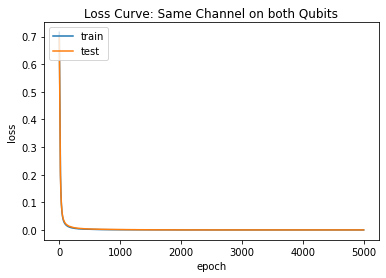

In [76]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 1.4839e-05 - 220ms/epoch - 55ms/step


In [78]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_inf = tf.math.reduce_mean(fid)
print(fid_one_inf)

tf.Tensor((1.0003947+3.1243485e-06j), shape=(), dtype=complex64)
